Histograms of global and site-level distributions

**Dimensions to expand:**
- PFTs (temperate vs. broadleaf vs. tropical)
- latitude
- regions
- elevation
- climate (P, T, VPD_CAN)
- biomes (?)



# Setup

## Packages

In [1]:
%load_ext watermark

import numpy as np
import xarray as xr
import pandas as pd
import xcdat as xc
import intake

import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import regionmask

import cmocean
import cmocean.cm as cmo

%watermark -iv

cmocean   : 3.0.3
xcdat     : 0.6.0
cartopy   : 0.22.0
matplotlib: 3.8.0
regionmask: 0.11.0
pandas    : 2.2.0
numpy     : 1.24.4
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
intake    : 0.0.0
xarray    : 2023.10.1



## Figure settings

In [2]:
%config InlineBackend.figure_formats = ['png']
mpl.rcParams['figure.dpi'] = 120

# Functions

In [3]:
def format_ds_coords(ds):
    ds = ds.bounds.add_bounds('X')
    ds = ds.bounds.add_bounds('Y')
    ds = xc.swap_lon_axis(ds, (-180, 180))
    return ds


def calculate_annual_timeseries(da):
    """
    Calculates the annual timeseries, weighted by the number of days in each month
    """
    nyears = len(da.groupby('time.year'))
    month_length = da.time.dt.days_in_month

    weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()        
    np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(nyears)) 

    return (da * weights).groupby('time.year').sum(dim='time')


def select_sites_from_gridded_data(xr_grid_data, df_site_data):
    """
    Creates a DataArray for the sites in a Dataframe.
    """
    nsite = df_site_data.iloc[:,0].size
    np_site_data = np.empty((nsite), dtype=xr.DataArray)

    # Select the grid box nearest to the coordinates for each site
    for i, row in df_site_data.iterrows():
        gridbox_timeseries = xr_grid_data.sel(lat=row['lat'], lon=row['lon'], method='nearest')
        np_site_data[i] = gridbox_timeseries

    xr_site_data = xr.concat(np_site_data, dim='site')
    xr_site_data = xr_site_data.assign_coords({'site': np.arange(nsite)})

    return xr_site_data


def replace_site_with_lat(site_da):
    """
    Create an identical DataArray replacing the (site) dimension with a (lat) dimension
    """
    if 'pft' in site_da.dims:
        lat_da = xr.DataArray(
            data=site_da.values,
            dims=['lat', 'pft'],
            coords=dict(
                pft=np.arange(15),
                lat=site_da.lat.values,
                lon=(['lat'], site_da.lon.values),
                site=(['lat'], site_da.site.values),
            ),
        )

    else:
        lat_da = xr.DataArray(
            data=site_da.values,
            dims=['lat'],
            coords=dict(
                lat=site_da.lat.values,
                lon=(['lat'], site_da.lon.values),
                site=(['lat'], site_da.site.values),
            ),
        )
    
    lat_da = lat_da.sortby(lat_da.lat)

    return lat_da


def get_unique_gridboxes(site_da, tree_ring_coords, other_class=None, to_print=False, verbose=False):
    """
    Given a pandas DataFrame of site coordinates, returns the list of
    site indices corresponding to unique grid boxes in CLM with optional
    additional plant type categories (ang or gym  / PFT)
    """
    n = site_da.size
    site_array = tree_ring_coords.reset_index(drop=True).index.values
    lon_array = site_da.lon.values
    lat_array = site_da.lat.values

    unique_gridbox_indices = []
    unique_coords = []
    repeat_coords = []

    # For each site, a list of sites (including itself) that share its grid box in CLM
    repeat_gridbox_indices = np.empty(n, dtype=object)
    for i in range(n):
        repeat_gridbox_indices[i] = [i]

    if other_class == 'pft':
        pft_array = tree_ring_coords['PFT'].values
        zipped_coords = zip(lon_array, lat_array, pft_array)
    if other_class == 'ang/gym':
        ang_gym_array = tree_ring_coords['isAng'].values
        zipped_coords = zip(lon_array, lat_array, ang_gym_array)
    if other_class is None:
        zipped_coords = zip(lon_array, lat_array)

    for s, coord in zip(site_array, zipped_coords):
        if coord in unique_coords:
            orig_site = site_array[unique_gridbox_indices[unique_coords.index(coord)]]

            if verbose:
                if other_class == 'pft':
                    print(f'{s} {coord[0]: 0.4f} {coord[1]: 0.4f} {coord[2]: 0.0f}')
                    print(f'{orig_site} {lon_array[orig_site]: 0.4f} {lat_array[orig_site]: 0.4f} {pft_array[orig_site]: 0.0f}', end='\n\n')
                
                if other_class == 'ang/gym':
                    print(f'{s} {coord[0]: 0.4f} {coord[1]: 0.4f} {coord[2]: 0.0f}')
                    print(f'{orig_site} {lon_array[orig_site]: 0.4f} {lat_array[orig_site]: 0.4f} {ang_gym_array[orig_site]: 0.0f}', end='\n\n')

                if other_class == None:
                    print(f'{s} {coord[0]: 0.4f} {coord[1]: 0.4f}')
                    print(f'{orig_site} {lon_array[orig_site]: 0.4f} {lat_array[orig_site]: 0.4f}', end='\n\n')

            for repeat_site in repeat_gridbox_indices[orig_site][1:]:
                repeat_gridbox_indices[repeat_site].append(s)
                repeat_gridbox_indices[s].append(repeat_site)
            repeat_gridbox_indices[orig_site].append(s)
            repeat_gridbox_indices[s].append(orig_site)

            repeat_coords.append(coord)

        else:
            unique_gridbox_indices.append(s)
            unique_coords.append(coord)


    # For each site, the number of sites (including itself) that share its grid box in CLM
    site_per_gridbox = np.ones(n)
    for i in range(n):
        site_per_gridbox[i] = len(repeat_gridbox_indices[i])

        # Sort the sites in the same grid box
        repeat_gridbox_indices[i] = sorted(repeat_gridbox_indices[i])

    if to_print:
        print('number of unique grid box coordinates:   ', len(unique_coords))
        print('number of repeated grid box coordinates: ', len(repeat_coords))
        print('total number of coordinates:             ', len(unique_coords) + len(repeat_coords))
    
    # Create output dictionary
    output_dict = {
        'unique_gridbox_indices': np.array(unique_gridbox_indices),
        'unique_coords': np.array(unique_coords),
        'repeat_gridbox_indices': repeat_gridbox_indices,
        'repeat_coords': np.array(repeat_coords),
        'site_per_gridbox': np.array(site_per_gridbox),
    }

    return output_dict

# Load data

## Site locations for slope (from Marja, new - use these)
**Notes:**
* there are no sites with PFT=8 (broadleaf_deciduous_boreal_tree)
* when I applied the same LAI filtering to the original latlon_pft.csv file, I got different sites (?)

In [4]:
latlon_slope = pd.read_pickle('./lat_lon_pft_slope.pkl')
latlon_pct = pd.read_pickle('./lat_lon_pft_percent_change.pkl')

latlon_slope_dict = {}
latlon_pct_dict = {}
for i, var in enumerate(['GPP', 'GSSUNLN', 'FCTR']):

    # For now, only analyze the full time period
    latlon_slope_dict[var] = latlon_slope[i][0].reset_index(names='original_index')
    latlon_pct_dict[var] = latlon_pct[i][0].reset_index(names='original_index')

    # Later, it may be useful to analyze the early and late time periods
    # latlon_slope_dict[var] = {}
    # latlon_pct_dict[var] = {}
    # for j, time_period in enumerate(['full', 'early', 'late']):
    #     latlon_slope_dict[var][time_period] = latlon_slope[i][j]

    #     latlon_pct_dict[var][time_period] = latlon_pct[i][j]

In [5]:
(latlon_slope_dict['GPP'] == latlon_slope_dict['GSSUNLN']).min()

original_index    True
lat               True
lon               True
PFT               True
dtype: bool

In [6]:
(latlon_slope_dict['GPP'] == latlon_slope_dict['FCTR']).min()

original_index    True
lat               True
lon               True
PFT               True
dtype: bool

In [7]:
# The site locations are the same for each variable, so only select one to use
tree_ring_coords = latlon_slope_dict['GPP']

## Site locations (from Marja, old - don't use these)

Text(0.5, 1.0, '[ blue=latlon_pft.csv | red=latlon_gym_ang.csv ]')

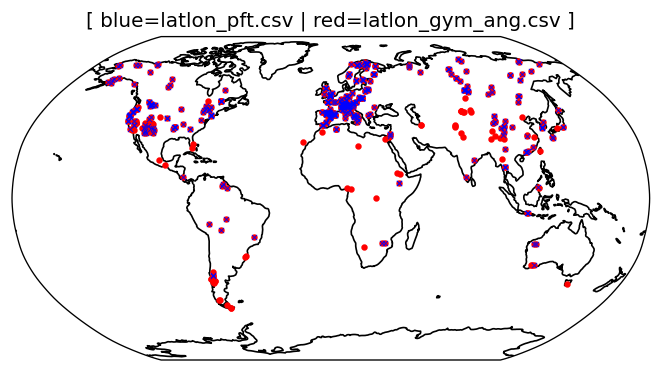

In [8]:
# Which latlon.csv file to use?

tree1 = pd.read_csv('./latlon_gym_ang.csv', usecols=[0,1])
tree2 = pd.read_csv('./latlon_pft.csv', usecols=[0,1])

fig, ax = plt.subplots(
    figsize=(8,3.5),
    subplot_kw={'projection': ccrs.Robinson()},
)

for i, row1 in tree1.iterrows():
    ax.scatter(
        row1['lon'], row1['lat'],
        s=8, color='red',
        transform=ccrs.PlateCarree()
    )

for i, row2 in tree2.iterrows():
    ax.scatter(
        row2['lon'], row2['lat'],
        s=10, marker='x', linewidth=0.5, color='blue',
        transform=ccrs.PlateCarree()
    )

ax.set_extent((-180, 180, -90, 90))
ax.coastlines(zorder=0)
ax.set_title('[ blue=latlon_pft.csv | red=latlon_gym_ang.csv ]')

In [20]:
tree_ring_coords = pd.read_csv('./latlon_pft.csv', usecols=[0,1,2,3])

# tree_ring_coords = tree_ring_coords.rename(columns={'gym=0/ang=1': 'isAng'})
# tree_ring_coords = tree_ring_coords.replace({'isAng': np.nan}, 2)

# ang_coords = tree_ring_coords.loc[tree_ring_coords['isAng']==1].drop(columns=['PFT'])
# gym_coords = tree_ring_coords.loc[tree_ring_coords['isAng']==0].drop(columns=['PFT'])

# pft_coords = []
# for i in range(0,8):
#     pft_coords.append(tree_ring_coords.loc[tree_ring_coords['PFT']==i].drop(columns=['isAng']))

## Percent PFT

In [10]:
pft_constants = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/lnd/clm2/paramdata/clm50_params.c210217.nc')
pftnames = pft_constants.pftname
pftnames = [ str(name.strip())[2:-1] for name in pftnames[0:15].values ]

In [11]:
natpft_gridbox = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/natpft_gridbox.nc')
pct_natpft_gridbox = natpft_gridbox['pct_natpft_gridbox']
area_natpft_gridbox = natpft_gridbox['area_natpft_gridbox']

In [8]:
%%time

ltype_name = [
    'vegetated_or_bare_soil',
    'crop',
    'UNUSED',
    'landice_multiple_elevation_classes',
    'deep_lake',
    'wetland',
    'urban_tbd',
    'urban_hd',
    'urban_md',
]

main_directory = '/glade/work/bbuchovecky/WUE_analysis'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'

pft_constants = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/lnd/clm2/paramdata/clm50_params.c210217.nc')
pftnames = pft_constants.pftname
pftnames = [ str(name.strip())[2:-1] for name in pftnames[0:15].values ]

pct_natpft = xr.open_dataset(f'{main_directory}/{case_name}.clm2.h3.PCT_NAT_PFT.18500101-20141231.nc')
pct_natpft = format_ds_coords(pct_natpft)
area_gridbox = pct_natpft['area']
pct_natpft = pct_natpft['PCT_NAT_PFT'].rename({'natpft':'pft'}).assign_coords({'pft':np.arange(15)}) / 100

pct_landunit = xr.open_dataset(f'{main_directory}/{case_name}.clm2.h3.PCT_LANDUNIT.18500101-20141231.nc')
pct_landunit = format_ds_coords(pct_landunit)
pct_landunit = pct_landunit['PCT_LANDUNIT'].assign_coords({'ltype':np.arange(9)}) / 100

pct_natpft_gridbox = pct_natpft * pct_landunit.isel(ltype=0)
area_natpft_gridbox = pct_natpft_gridbox * area_gridbox

CPU times: user 7.2 s, sys: 4min 28s, total: 4min 35s
Wall time: 4min 45s


In [20]:
xr.merge([
    xr.DataArray(
        data=pct_natpft_gridbox.values,
        dims=['time', 'pft', 'lat', 'lon'],
        coords=dict(
            time=pct_natpft_gridbox.time,
            pft=pct_natpft_gridbox.pft,
            lat=pct_natpft_gridbox.lat,
            lon=pct_natpft_gridbox.lon,
            pft_name=(('pft'), pftnames)
        ),
        name='pct_natpft_gridbox',
        attrs=dict(
            long_name='percent of area in grid box occupied by PFT'
        )
    ),
    xr.DataArray(
        data=area_natpft_gridbox.values,
        dims=['time', 'pft', 'lat', 'lon'],
        coords=dict(
            time=area_natpft_gridbox.time,
            pft=area_natpft_gridbox.pft,
            lat=area_natpft_gridbox.lat,
            lon=area_natpft_gridbox.lon,
            pft_name=(('pft'), pftnames)
        ),
        name='area_natpft_gridbox',
        attrs=dict(
            long_name='area in grid box occupied by PFT'
        )
    )
]).to_netcdf('/glade/work/bbuchovecky/WUE_analysis/natpft_gridbox.nc')

## LAI

### Monthly (Marja's method, use this)
Here, I mask out any grid boxes where the maximum monthly LAI (for each year) drops below the threshold at any year in the timeseries

In [9]:
%%time

# PFT-level
main_directory = '/glade/work/bbuchovecky/WUE_analysis'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'
tlai_h1 = xr.open_dataset(f'{main_directory}/{case_name}.clm2.h1.TLAI.185001-201412_gridded.nc')
tlai_h1 = tlai_h1.rename({'vegtype': 'pft', 'vegtype_name': 'pft_name'}).sel(pft=slice(0,14))
tlai_h1 = format_ds_coords(tlai_h1)
tlai_h1 = tlai_h1['TLAI'].sel(time=slice('1901-01', '2014-12'))
# tlai_h1 = tlai_h1['TLAI'].sel(time=slice('1851-01', '2014-12'))

# gridbox-level
main_directory = '/glade/campaign/cgd/tss/common/Land_Only_Simulations/CTSM51_DEV/CLM50_CTSM51_LAND_ONLY_RELEASE'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'
tlai_h0 = xr.open_dataset(f'{main_directory}/{case_name}/lnd/proc/tseries/month_1/{case_name}.clm2.h0.TLAI.185001-201412.nc')
tlai_h0 = format_ds_coords(tlai_h0)
tlai_h0 = tlai_h0['TLAI'].sel(time=slice('1901-01', '2014-12'))
# tlai_h0 = tlai_h0['TLAI'].sel(time=slice('1851-01', '2014-12'))

# create mask 
# -> compare the maximum monthly LAI for each year to the threshold
# -> mask grid boxes where the LAI drops below the threshold at any year in the timeseries
# -> save to netcdf since the file is the computation takes a while
min_lai_threshold = 0.25
# alive_laipft_mask = (tlai_h1.resample(time='Y').max() > min_lai_threshold).min(dim='time')
alive_lai_mask = (tlai_h0.resample(time='Y').max() > min_lai_threshold).min(dim='time')

# alive_laipft_mask.rename({'vegtype': 'pft', 'vegtype_name': 'pft_name'}).sel(pft=slice(0,14)).to_netcdf('/glade/work/bbuchovecky/WUE_analysis/mask_greater_lai0p25.nc')

CPU times: user 1.39 s, sys: 156 ms, total: 1.54 s
Wall time: 3.92 s


In [25]:
alive_laipft_mask = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/mask_greater_lai0p25.nc')['TLAI']
# alive_lai_mask = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/alive_lai_mask.nc')['alive_lai_mask']

### Comparing Marja's site locations (old csv vs. new pickle)
**Notes:**
* The older csv file with PFT classifications has 453 sites while the newer pickle file only has 178, presumably due to LAI filtering.
* Following Marja's LAI filtering method (see above), I wanted to check that I get the same sites after filtering but I do not (see below).
* Could this be caused by the time period selection when creating the LAI mask? I use 1901-2014, would the filtering be different if I used 1851-2014?


In [ ]:
old_latlon_csv= pd.read_csv('./latlon_pft.csv', usecols=[0,1,2,3])
alive_laipft_mask = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/mask_greater_lai0p25.nc')['TLAI']

In [ ]:
marja_latlon_slope = latlon_slope_dict['GPP']

is_pft_lai_greater_0p25 = []
total_sites = 0

# Iterate through all tree PFTs
for tree_pft in range(1,9):
    sites = []

    # Iterate through site locations with the specified tree PFT
    for i, row in old_latlon_csv.loc[old_latlon_csv.PFT==tree_pft].iterrows():
        # Select the value from the LAI mask corresponding to the specified location and tree PFT
        sites.append(alive_laipft_mask.sel(lat=row['lat'], lon=row['lon'], pft=tree_pft, method='nearest').item())
    
    # Store the list of sites for the specified tree PFT
    is_pft_lai_greater_0p25.append(sites)

    # Compare to Marja's new site locations
    latlon_slope_dict['GPP']

    total_sites += np.array(sites).sum()
    print(f'PFT={tree_pft} {str(alive_laipft_mask.sel(pft=tree_pft).pft_name.item().strip())[2:-1]}')
    print(f' -> these sites above LAI threshold: {np.array(sites).sum()}')
    print(f' -> Marja sites above LAI threshold: {marja_latlon_slope.loc[marja_latlon_slope.PFT==tree_pft].iloc[:,0].size}')

print(f'---------------------------------------------')
print(f'total sites above LAI threshold: {total_sites}')

PFT=1 needleleaf_evergreen_temperate_tree
 -> these sites above LAI threshold: 178
 -> Marja sites above LAI threshold: 92
PFT=2 needleleaf_evergreen_boreal_tree
 -> these sites above LAI threshold: 18
 -> Marja sites above LAI threshold: 10
PFT=3 needleleaf_deciduous_boreal_tree
 -> these sites above LAI threshold: 16
 -> Marja sites above LAI threshold: 15
PFT=4 broadleaf_evergreen_tropical_tree
 -> these sites above LAI threshold: 17
 -> Marja sites above LAI threshold: 10
PFT=5 broadleaf_evergreen_temperate_tree
 -> these sites above LAI threshold: 0
 -> Marja sites above LAI threshold: 0
PFT=6 broadleaf_deciduous_tropical_tree
 -> these sites above LAI threshold: 0
 -> Marja sites above LAI threshold: 0
PFT=7 broadleaf_deciduous_temperate_tree
 -> these sites above LAI threshold: 97
 -> Marja sites above LAI threshold: 52
PFT=8 broadleaf_deciduous_boreal_tree
 -> these sites above LAI threshold: 1
 -> Marja sites above LAI threshold: 0
---------------------------------------------

### Annual (my old method, don't use this)
Here, I mask out any grid boxes where the minimum annual mean LAI drops below the threshold at any year in the timeseries. This is more selective than Marja's method.

In [ ]:
%%time

# PFT-level
main_directory = '/glade/work/bbuchovecky/WUE_analysis'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'
tlai_ann_h1 = xr.open_dataset(f'{main_directory}/timeseries_from_gridded/{case_name}.clm2.h1.TLAI.185001-201412_gridded_annts.nc')
tlai_ann_h1 = format_ds_coords(tlai_ann_h1)
tlai_ann_h1 = tlai_ann_h1['TLAI'].sel(year=slice(1901, 2014))

# gridbox-level
main_directory = '/glade/campaign/cgd/tss/common/Land_Only_Simulations/CTSM51_DEV/CLM50_CTSM51_LAND_ONLY_RELEASE'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'
tlai_ann_h0 = xr.open_dataset(f'{main_directory}/{case_name}/lnd/proc/tseries/month_1/{case_name}.clm2.h0.TLAI.185001-201412.nc')
tlai_ann_h0 = format_ds_coords(tlai_ann_h0)
tlai_ann_h0 = calculate_annual_timeseries(tlai_ann_h0['TLAI'])
tlai_ann_h0 = tlai_ann_h0.sel(year=slice(1901, 2014))

# create mask
min_lai_threshold = 0.25
alive_ann_laipft_mask = xr.where(tlai_ann_h1.min(dim='year')>min_lai_threshold, 1, 0)
alive_ann_lai_mask = xr.where(tlai_ann_h0.min(dim='year')>min_lai_threshold, 1, 0)

CPU times: user 6.32 s, sys: 43.7 s, total: 50 s
Wall time: 57.3 s


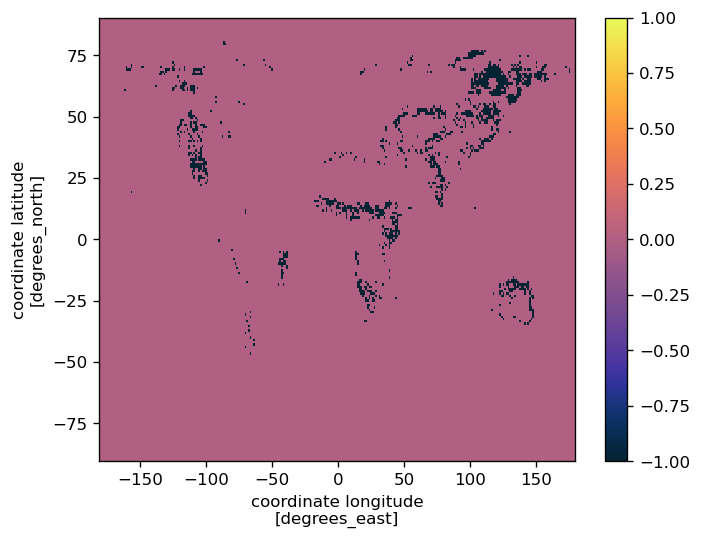

In [ ]:
(alive_ann_lai_mask - alive_lai_mask).plot(vmin=-1, vmax=1, cmap=cmo.thermal)

# Unique grid boxes
The tree ring locations are clumped together, so in some cases multiple tree ring points occupy the same CLM grid box. Here, I create a mask to only select unique CLM grid boxes that correspond to tree ring locations and omit any repeated CLM grid boxes.

In [21]:
main_directory = '/glade/campaign/cgd/tss/common/Land_Only_Simulations/CTSM51_DEV/CLM50_CTSM51_LAND_ONLY_RELEASE'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'
da = xr.open_dataset(f'{main_directory}/{case_name}/lnd/proc/tseries/month_1/{case_name}.clm2.h0.TLAI.185001-201412.nc')
da = da['TLAI'].isel(time=0)
site_da = select_sites_from_gridded_data(da, tree_ring_coords)

unique_repeat_dict = get_unique_gridboxes(site_da, tree_ring_coords, other_class='pft', to_print=True)
unique_gridbox_indices = unique_repeat_dict['unique_gridbox_indices']

number of unique grid box coordinates:    216
number of repeated grid box coordinates:  238
total number of coordinates:              454


# Zonal plots (PFT area and TLAI)

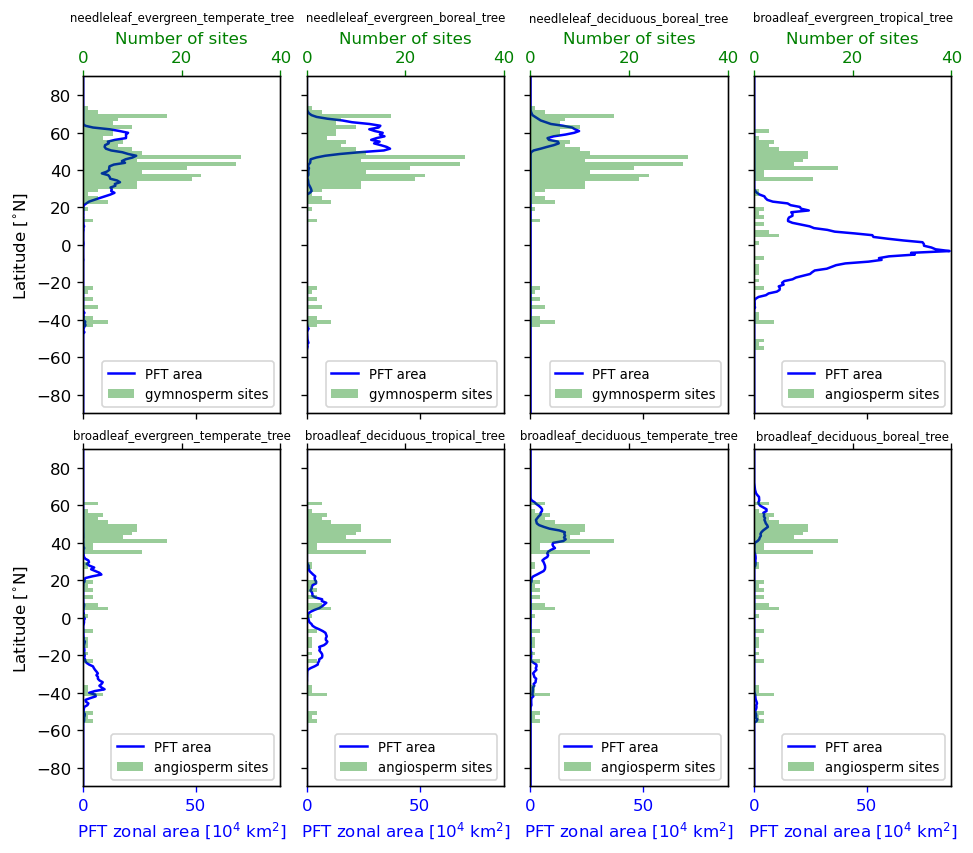

In [ ]:
fig, axes = plt.subplots(
    2, 4, figsize=(8, 7),
    layout='constrained',
    sharey=True,
)
ax = axes.ravel()
ax_sites = np.empty(ax.size, dtype=object)

for i in range(8):
    ax_sites[i] = ax[i].twiny()

    if i+1 < 4:
        ax_sites[i].hist(
            x=gym_coords.lat.values,
            bins=np.arange(-90, 90+0.1, 2),
            orientation='horizontal',
            color='green', alpha=0.4,
            label='gymnosperm sites')
    
    if i+1 >= 4:
        ax_sites[i].hist(
            x=ang_coords.lat.values,
            bins=np.arange(-90, 90+0.1, 2),
            orientation='horizontal',
            color='green', alpha=0.4,
            label='angiosperm sites')

    ax_sites[i].set_xlim(0, 40)

    ax[i].plot(
        area_natpft_gridbox.sel(pft=i+1, time=slice('1901','2014')).mean(dim='time').sum(dim='lon').values / 10000,
        area_natpft_gridbox.lat.values,
        color='blue', zorder=100,
        label='PFT area',
    )

    ax[i].set_title(pftnames[i+1], fontsize=7)
    ax[i].set_xlim(0, 87.5)
    ax[i].set_ylim(-90, 90)
    
    pft_ln, pft_lb = ax[i].get_legend_handles_labels()
    site_ln, site_lb = ax_sites[i].get_legend_handles_labels()
    ax[i].legend(
        pft_ln + site_ln, pft_lb + site_lb,
        loc='lower right', fontsize=8)
    

ax[0].set_ylabel('Latitude [$^{\circ}$N]')
ax[4].set_ylabel('Latitude [$^{\circ}$N]')

for i in range(0,4):
    ax_sites[i].set_xlabel('Number of sites')
    ax_sites[i].tick_params(axis='x', colors='green')
    ax_sites[i].xaxis.label.set_color('green')
    ax[i].set_xticklabels([])

for i in range(4,8):
    ax[i].set_xlabel('PFT zonal area [10$^4$ km$^2$]')
    ax[i].tick_params(axis='x', colors='blue')
    ax[i].xaxis.label.set_color('blue')
    ax_sites[i].set_xticklabels([])

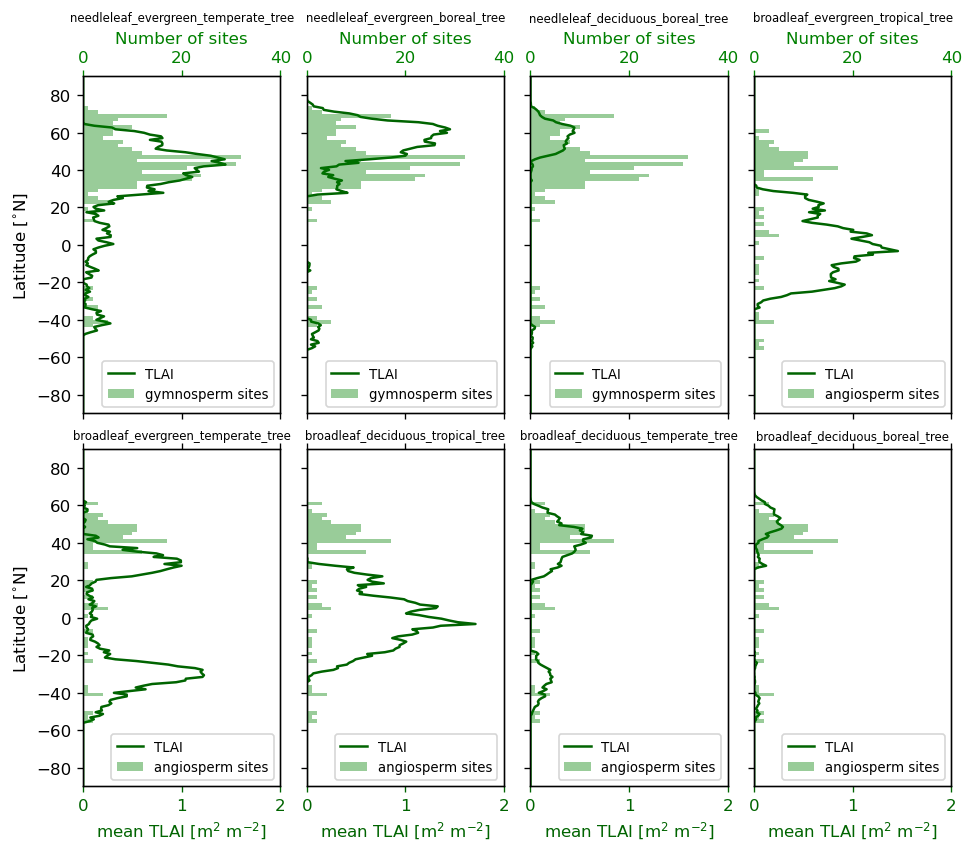

In [ ]:
fig, axes = plt.subplots(
    2, 4, figsize=(8, 7),
    layout='constrained',
    sharey=True,
)
ax = axes.ravel()
ax_sites = np.empty(ax.size, dtype=object)

for i in range(8):
    ax_sites[i] = ax[i].twiny()

    if i+1 < 4:
        ax_sites[i].hist(
            x=gym_coords.lat.values,
            bins=np.arange(-90, 90+0.1, 2),
            orientation='horizontal',
            color='green', alpha=0.4,
            label='gymnosperm sites')
    
    if i+1 >= 4:
        ax_sites[i].hist(
            x=ang_coords.lat.values,
            bins=np.arange(-90, 90+0.1, 2),
            orientation='horizontal',
            color='green', alpha=0.4,
            label='angiosperm sites')

    ax_sites[i].set_xlim(0, 40)

    ax[i].plot(
        tlai.sel(pft=i+1, year=slice(1901,2014)).mean(dim=['year', 'lon'], skipna=True).values,
        tlai.lat.values,
        color='darkgreen', zorder=100,
        label='TLAI',
    )

    ax[i].set_title(pftnames[i+1], fontsize=7)
    ax[i].set_xlim(0, 2)
    ax[i].set_ylim(-90, 90)
    
    pft_ln, pft_lb = ax[i].get_legend_handles_labels()
    site_ln, site_lb = ax_sites[i].get_legend_handles_labels()
    ax[i].legend(
        pft_ln + site_ln, pft_lb + site_lb,
        loc='lower right', fontsize=8)
    

ax[0].set_ylabel('Latitude [$^{\circ}$N]')
ax[4].set_ylabel('Latitude [$^{\circ}$N]')

for i in range(0,4):
    ax_sites[i].set_xlabel('Number of sites')
    ax_sites[i].tick_params(axis='x', colors='green')
    ax_sites[i].xaxis.label.set_color('green')
    ax[i].set_xticklabels([])

for i in range(4,8):
    ax[i].set_xlabel('mean TLAI [m$^2$ m$^{-2}$]')
    ax[i].tick_params(axis='x', colors='darkgreen')
    ax[i].xaxis.label.set_color('darkgreen')
    ax_sites[i].set_xticklabels([])

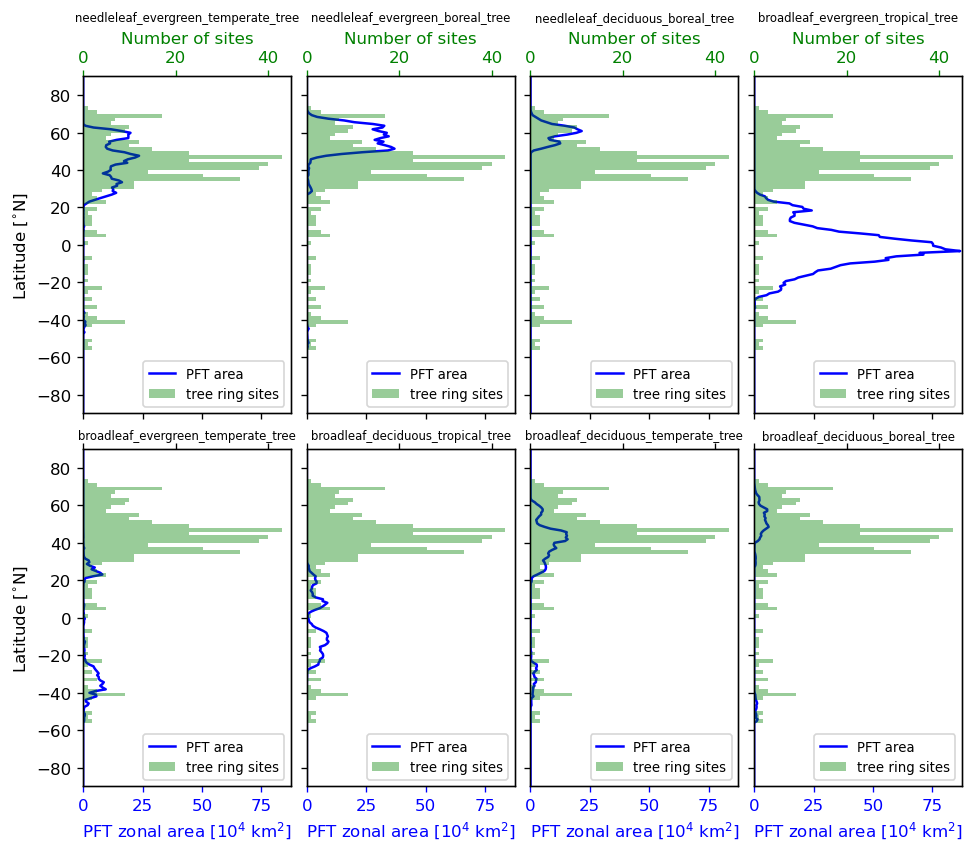

In [ ]:
fig, axes = plt.subplots(
    2, 4, figsize=(8, 7),
    layout='constrained',
    sharey=True,
)
ax = axes.ravel()
ax_sites = np.empty(ax.size, dtype=object)

for i in range(8):
    ax_sites[i] = ax[i].twiny()
    ax_sites[i].hist(
        x=tree_ring_coords.lat.values,
        bins=np.arange(-90, 90+0.1, 2),
        orientation='horizontal',
        color='green', alpha=0.4,
        label='tree ring sites')

    ax_sites[i].set_xlim(0, 45)

    ax[i].plot(
        area_natpft_gridbox.sel(pft=i+1, time=slice('1901','2014')).mean(dim='time').sum(dim='lon').values / 10000,
        area_natpft_gridbox.lat.values,
        color='blue', zorder=100,
        label='PFT area',
    )

    ax[i].set_title(pftnames[i+1], fontsize=7)
    ax[i].set_xlim(0, 87.5)
    ax[i].set_ylim(-90, 90)
    
    pft_ln, pft_lb = ax[i].get_legend_handles_labels()
    site_ln, site_lb = ax_sites[i].get_legend_handles_labels()
    ax[i].legend(
        pft_ln + site_ln, pft_lb + site_lb,
        loc='lower right', fontsize=8)
    

ax[0].set_ylabel('Latitude [$^{\circ}$N]')
ax[4].set_ylabel('Latitude [$^{\circ}$N]')

for i in range(0,4):
    ax_sites[i].set_xlabel('Number of sites')
    ax_sites[i].tick_params(axis='x', colors='green')
    ax_sites[i].xaxis.label.set_color('green')
    ax[i].set_xticklabels([])

for i in range(4,8):
    ax[i].set_xlabel('PFT zonal area [10$^4$ km$^2$]')
    ax[i].tick_params(axis='x', colors='blue')
    ax[i].xaxis.label.set_color('blue')
    ax_sites[i].set_xticklabels([])

Text(0, 0.5, 'Latitude [$^{\\circ}$N]')

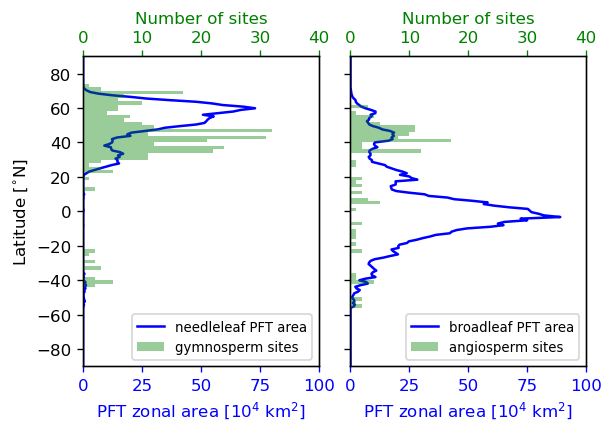

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(5, 3.5),
    layout='constrained',
    sharey=True,
)
ax = axes.ravel()
ax_sites = np.empty(ax.size, dtype=object)

for i, (site_class, pft_class, pft_slice) in enumerate(zip(['gym', 'ang'], ['needleleaf', 'broadleaf'], [slice(1,3), slice(4,8)])):
    ax_sites[i] = ax[i].twiny()

    if site_class == 'gym':
        ax_sites[i].hist(
            x=gym_coords.lat.values,
            bins=np.arange(-90, 90+0.1, 2),
            orientation='horizontal',
            color='green', alpha=0.4,
            label='gymnosperm sites')
    
    if site_class == 'ang':
        ax_sites[i].hist(
            x=ang_coords.lat.values,
            bins=np.arange(-90, 90+0.1, 2),
            orientation='horizontal',
            color='green', alpha=0.4,
            label='angiosperm sites')

    ax[i].plot(
        area_natpft_gridbox.sel(pft=pft_slice, time=slice('1901','2014')).mean(dim='time').sum(dim=['lon', 'pft']).values / 10000,
        area_natpft_gridbox.lat.values,
        color='blue', zorder=100,
        label=f'{pft_class} PFT area',
    )
    
    pft_ln, pft_lb = ax[i].get_legend_handles_labels()
    site_ln, site_lb = ax_sites[i].get_legend_handles_labels()
    ax[i].legend(
        pft_ln + site_ln, pft_lb + site_lb,
        loc='lower right', fontsize=8)
    
    ax_sites[i].set_xlim(0, 40)

    ax[i].set_xlim(0, 100)
    ax[i].set_ylim(-90, 90)

    ax_sites[i].set_xlabel('Number of sites')
    ax_sites[i].tick_params(axis='x', colors='green')
    ax_sites[i].xaxis.label.set_color('green')

    ax[i].set_xlabel('PFT zonal area [10$^4$ km$^2$]')
    ax[i].tick_params(axis='x', colors='blue')
    ax[i].xaxis.label.set_color('blue')

ax[0].set_ylabel('Latitude [$^{\circ}$N]')

Text(0, 0.5, 'Latitude [$^{\\circ}$N]')

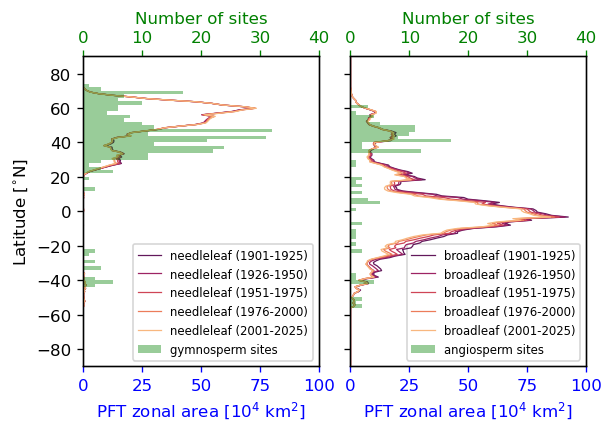

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(5, 3.5),
    layout='constrained',
    sharey=True,
)
ax = axes.ravel()
ax_sites = np.empty(ax.size, dtype=object)

time_period_length = 25
cmap = cmo.matter_r
cmap = cmocean.tools.crop_by_percent(cmap, 30, which='both', N=None)
colors = cmap(np.linspace(0, 1, (2014-1901)//time_period_length+1))

for i, (site_class, pft_class, pft_slice) in enumerate(zip(['gym', 'ang'], ['needleleaf', 'broadleaf'], [slice(1,3), slice(4,8)])):
    ax_sites[i] = ax[i].twiny()

    if site_class == 'gym':
        ax_sites[i].hist(
            x=gym_coords.lat.values,
            bins=np.arange(-90, 90+0.1, 2),
            orientation='horizontal',
            color='green', alpha=0.4,
            label='gymnosperm sites')
    
    if site_class == 'ang':
        ax_sites[i].hist(
            x=ang_coords.lat.values,
            bins=np.arange(-90, 90+0.1, 2),
            orientation='horizontal',
            color='green', alpha=0.4,
            label='angiosperm sites')

    for j, time_start in enumerate(np.arange(1901, 2014, time_period_length)):
        ax[i].plot(
            area_natpft_gridbox.sel(pft=pft_slice, time=slice(str(time_start),str(time_start+time_period_length-1))).mean(dim='time').sum(dim=['lon', 'pft']).values / 10000,
            area_natpft_gridbox.lat.values,
            color=colors[j], lw=0.75, zorder=100,
            label=f'{pft_class} ({time_start}-{time_start+time_period_length-1})',
        )
    
    pft_ln, pft_lb = ax[i].get_legend_handles_labels()
    site_ln, site_lb = ax_sites[i].get_legend_handles_labels()
    ax[i].legend(
        pft_ln + site_ln, pft_lb + site_lb,
        loc='lower right', fontsize=7)
    
    ax_sites[i].set_xlim(0, 40)

    ax[i].set_xlim(0, 100)
    ax[i].set_ylim(-90, 90)

    ax_sites[i].set_xlabel('Number of sites')
    ax_sites[i].tick_params(axis='x', colors='green')
    ax_sites[i].xaxis.label.set_color('green')

    ax[i].set_xlabel('PFT zonal area [10$^4$ km$^2$]')
    ax[i].tick_params(axis='x', colors='blue')
    ax[i].xaxis.label.set_color('blue')

ax[0].set_ylabel('Latitude [$^{\circ}$N]')

Text(0, 0.5, 'Latitude [$^{\\circ}$N]')

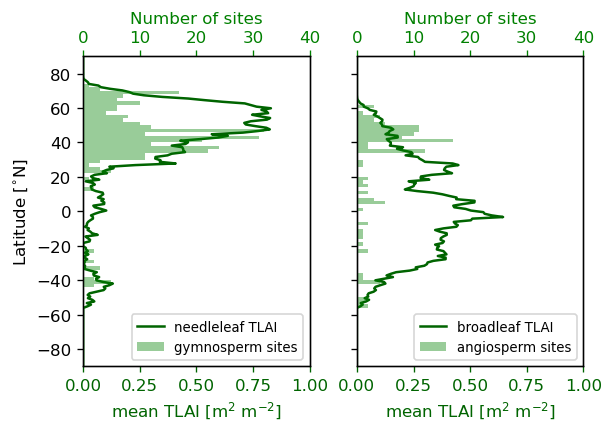

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(5, 3.5),
    layout='constrained',
    sharey=True,
)
ax = axes.ravel()
ax_sites = np.empty(ax.size, dtype=object)

for i, (site_class, pft_class, pft_slice) in enumerate(zip(['gym', 'ang'], ['needleleaf', 'broadleaf'], [slice(1,3), slice(4,8)])):
    ax_sites[i] = ax[i].twiny()

    if site_class == 'gym':
        ax_sites[i].hist(
            x=gym_coords.lat.values,
            bins=np.arange(-90, 90+0.1, 2),
            orientation='horizontal',
            color='green', alpha=0.4,
            label='gymnosperm sites')
    
    if site_class == 'ang':
        ax_sites[i].hist(
            x=ang_coords.lat.values,
            bins=np.arange(-90, 90+0.1, 2),
            orientation='horizontal',
            color='green', alpha=0.4,
            label='angiosperm sites')

    ax[i].plot(
        tlai.sel(pft=pft_slice, year=slice(1901, 2014)).mean(dim=['year', 'lon', 'pft']).values,
        tlai.lat.values,
        color='darkgreen', zorder=100,
        label=f'{pft_class} TLAI',
    )
    
    pft_ln, pft_lb = ax[i].get_legend_handles_labels()
    site_ln, site_lb = ax_sites[i].get_legend_handles_labels()
    ax[i].legend(
        pft_ln + site_ln, pft_lb + site_lb,
        loc='lower right', fontsize=8)
    
    ax_sites[i].set_xlim(0, 40)

    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(-90, 90)

    ax_sites[i].set_xlabel('Number of sites')
    ax_sites[i].tick_params(axis='x', colors='green')
    ax_sites[i].xaxis.label.set_color('green')

    ax[i].set_xlabel('mean TLAI [m$^2$ m$^{-2}$]')
    ax[i].tick_params(axis='x', colors='darkgreen')
    ax[i].xaxis.label.set_color('darkgreen')

ax[0].set_ylabel('Latitude [$^{\circ}$N]')

# Trends for h1 variables

In [22]:
%%time

main_directory = '/glade/work/bbuchovecky/WUE_analysis'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'

variable_h1 = [
    'GPP',
    'GSSUNLN',
    'FCTR',
    'TLAI',
    'BTRANMN',
    'WUE',
]

conv_factors = {
    'GPP': 60 * 60 * 24 * 365,
    'GSSUNLN': 1 / 1000,
    'FCTR': 1000 * 1000 / 2.26e6,
    'TLAI': 1,
    'BTRANMN': 1,
    'WUE': 1,
}

time_period_in_years = {
    'full':  '1901-2014',
    # 'early': '1901-1964',
    # 'late':  '1965-2014',
}

trends_h1 = {}
slopes_h1 = {}
pred_h1 = {}

site_trends_h1 = {}
site_slopes_h1 = {}
site_pred_h1 = {}

unique_site_trends_h1 = {}
unique_site_slopes_h1 = {}
unique_site_pred_h1 = {}

for dd in [
    trends_h1, slopes_h1, pred_h1,
    site_trends_h1, site_slopes_h1, site_pred_h1,
    unique_site_trends_h1, unique_site_slopes_h1, unique_site_pred_h1
    ]:
    dd['full'] = {}
    dd['early'] = {}
    dd['late'] = {}

for var in variable_h1:
    print(var)
    for key, period in time_period_in_years.items():
        # Get all degree=1 polyfit statistics
        trends_h1[key][var] = xr.open_dataset(f'{main_directory}/trends/gridded/{var}_coeff.annts.{period}.nc')
        trends_h1[key][var] = format_ds_coords(trends_h1[key][var])
        trends_h1[key][var] = trends_h1[key][var].where(alive_laipft_mask) * conv_factors[var]

        # Get only the slope of the degree=1 polyfit
        slopes_h1[key][var] = trends_h1[key][var]['polyfit_coefficients'].sel(degree=1) * 10

        # Get the predicted values from the degree=1 polyfit
        # pred_h1[key][var] = xr.open_dataset(f'{main_directory}/trends/gridded/{var}_pred.annts.{period}.nc')
        # pred_h1[key][var] = format_ds_coords(pred_h1[key][var])
        # pred_h1[key][var] = pred_h1[key][var][var+'_pred']
        # pred_h1[key][var] = pred_h1[key][var].where(alive_laipft_mask)

        # Get the site-level polyfit values
        site_trends_h1[key][var] = select_sites_from_gridded_data(trends_h1[key][var], tree_ring_coords)
        site_slopes_h1[key][var] = select_sites_from_gridded_data(slopes_h1[key][var], tree_ring_coords)
        # site_pred_h1[key][var] = select_sites_from_gridded_data(slopes_h1[key][var], tree_ring_coords)

        # Get only the sites in unique grid boxes
        unique_site_trends_h1[key][var] = site_trends_h1[key][var].isel(site=unique_gridbox_indices)
        unique_site_slopes_h1[key][var] = site_slopes_h1[key][var].isel(site=unique_gridbox_indices)
        # unique_site_pred_h1[key][var] = site_slopes_h1[key][var].isel(site=unique_gridbox_indices) 

2024-06-27 13:11:03,346 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-06-27 13:11:03,346 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


GPP


2024-06-27 13:11:04,929 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-06-27 13:11:04,929 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


GSSUNLN
FCTR


2024-06-27 13:11:06,761 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-06-27 13:11:06,761 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-06-27 13:11:08,203 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-06-27 13:11:08,203 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


TLAI


2024-06-27 13:11:09,382 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-06-27 13:11:09,382 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


BTRANMN


2024-06-27 13:11:10,825 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-06-27 13:11:10,825 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


WUE
CPU times: user 7.38 s, sys: 140 ms, total: 7.52 s
Wall time: 8.71 s


# Trends for h0 variables

In [23]:
%%time

main_directory = '/glade/work/bbuchovecky/WUE_analysis'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'

variable_h0 = [
    'TLAI',
    'VPD_CAN',
    'RAIN_FROM_ATM',
    'RH2M',
    'TSA',
    # 'SOILLIQ',
]

conv_factors = {
    'TLAI': 1,
    'VPD_CAN': 1,
    'RAIN_FROM_ATM': 60 * 60 * 24,
    'RH2M': 1,
    'TSA': 1,
    # 'SOILLIQ': ,
}

time_period_in_years = {
    'full':  '1901-2014',
    'early': '1901-1964',
    'late':  '1965-2014',
}

trends_h0 = {}
slopes_h0 = {}
pred_h0 = {}

site_trends_h0 = {}
site_slopes_h0 = {}
site_pred_h0 = {}

unique_site_trends_h0 = {}
unique_site_slopes_h0 = {}
unique_site_pred_h0 = {}

for dd in [
    trends_h0, slopes_h0, pred_h0,
    site_trends_h0, site_slopes_h0, site_pred_h0,
    unique_site_trends_h0, unique_site_slopes_h0, unique_site_pred_h0,
    ]:
    dd['full'] = {}
    dd['early'] = {}
    dd['late'] = {}

for var in variable_h0:
    print(var)
    for key, period in time_period_in_years.items():
        # Get all degree=1 polyfit statistics
        trends_h0[key][var] = xr.open_dataset(f'{main_directory}/trends/gridded/{var}_coeff.annts.{period}.nc')
        trends_h0[key][var] = format_ds_coords(trends_h0[key][var])
        # trends_h0[key][var] = trends_h0[key][var].where(alive_natpft_mask) * conv_factors[var]
        # trends_h0[key][var] = trends_h0[key][var].where(alive_laipft_mask) * conv_factors[var]
        trends_h0[key][var] = trends_h0[key][var].where(alive_lai_mask) * conv_factors[var]

        # Get only the slope of the degree=1 polyfit
        slopes_h0[key][var] = trends_h0[key][var]['polyfit_coefficients'].sel(degree=1) * 10

        # Get the predicted values from the degree=1 polyfit
        # pred_h0[key][var] = xr.open_dataset(f'{main_directory}/trends/gridded/{var}_pred.annts.{period}.nc')
        # pred_h0[key][var] = format_ds_coords(pred_h0[key][var])
        # pred_h0[key][var] = pred_h0[key][var][var+'_pred']
        # pred_h0[key][var] = pred_h0[key][var].where(alive_natpft_mask)
        # pred_h0[key][var] = pred_h0[key][var].where(alive_laipft_mask)
        # pred_h0[key][var] = pred_h0[key][var].where(alive_lai_mask)

        # Get the site-level polyfit values
        site_trends_h0[key][var] = select_sites_from_gridded_data(trends_h0[key][var], tree_ring_coords)
        site_slopes_h0[key][var] = select_sites_from_gridded_data(slopes_h0[key][var], tree_ring_coords)
        # site_pred_h0[key][var] = select_sites_from_gridded_data(slopes_h0[key][var], tree_ring_coords)

        # Get only the sites in unique grid boxes
        unique_site_trends_h0[key][var] = site_trends_h0[key][var].isel(site=unique_gridbox_indices)
        unique_site_slopes_h0[key][var] = site_slopes_h0[key][var].isel(site=unique_gridbox_indices)
        # unique_site_pred_h0[key][var] = site_slopes_h0[key][var].isel(site=unique_gridbox_indices)

2024-06-27 13:11:11,971 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-06-27 13:11:11,971 [WARNING]: bounds.py(create_bounds:929) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


TLAI


NameError: name 'alive_lai_mask' is not defined

# Global

## Climate h0 variables

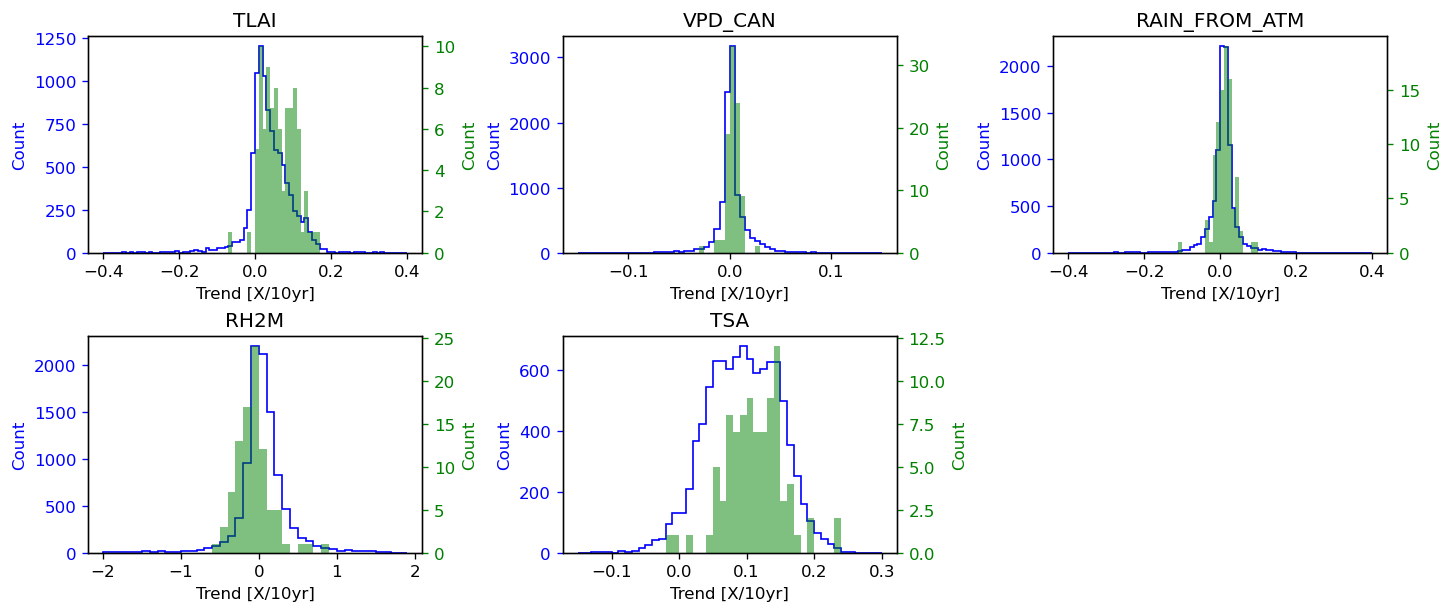

In [62]:
fig, axes = plt.subplots(
    2, 3,
    figsize=(12,5),
    layout='constrained'
)
ax = axes.ravel()
ax_site = np.empty(ax.size, dtype=object)

bins = {
    'TLAI': np.arange(-0.4, 0.4+1e-5, 0.01),
    'VPD_CAN': np.arange(-0.15, 0.15+1e-5, 0.005),
    'RAIN_FROM_ATM': np.arange(-0.4, 0.4+1e-5, 0.01),
    'RH2M': np.arange(-2, 2, 0.1),
    'TSA': np.arange(-0.15, 0.3+1e-5, 0.01),
}

for i, var in enumerate(variable_h0):
    ax_site[i] = ax[i].twinx()

    ax[i].hist(
        slopes_h0['full'][var].values.ravel(),
        bins=bins[var],
        histtype='step',
        color='blue'
    )
    ax[i].set_ylabel('Count')
    ax[i].tick_params(axis='y', colors='blue')
    ax[i].yaxis.label.set_color('blue')

    ax_site[i].hist(
        unique_site_slopes_h0['full'][var].values.ravel(),
        bins=bins[var],
        histtype='stepfilled',
        color='green', alpha=0.5,
    )
    ax_site[i].set_ylabel('Count')
    ax_site[i].tick_params(axis='y', colors='green')
    ax_site[i].yaxis.label.set_color('green')

    ax[i].set_title(f'{var}')
    ax[i].set_xlabel('Trend [X/10yr]')

ax[-1].remove()

In [64]:
slopes_h1['full']['GPP'].sel(pft=slice(1,8)).pft_name.values

array([b'needleleaf_evergreen_temperate_tree     ',
       b'needleleaf_evergreen_boreal_tree        ',
       b'needleleaf_deciduous_boreal_tree        ',
       b'broadleaf_evergreen_tropical_tree       ',
       b'broadleaf_evergreen_temperate_tree      ',
       b'broadleaf_deciduous_tropical_tree       ',
       b'broadleaf_deciduous_temperate_tree      ',
       b'broadleaf_deciduous_boreal_tree         '], dtype='|S40')

## Vegetation h1 variables

In [16]:
def global_hist_h1(var, bins, grouping):
    if grouping == 'pft':
        fig, axes = plt.subplots(
            2, 4,
            figsize=(12,5),
            layout='constrained',
        )
        ax = axes.ravel()
        ax_site = np.empty(ax.size, dtype=object)

        for i in range(8):
            ax_site[i] = ax[i].twinx()

            ax[i].hist(
                slopes_h1['full'][var].sel(pft=i+1).values.ravel(),
                bins=bins,
                histtype='step',
                color='blue'
            )
            ax[i].set_ylabel('Count')
            ax[i].tick_params(axis='y', colors='blue')
            ax[i].yaxis.label.set_color('blue')

            ax_site[i].hist(
                unique_site_slopes_h1['full'][var].sel(pft=i+1).values.ravel(),
                bins=bins,
                histtype='stepfilled',
                color='green', alpha=0.5,
            )
            ax_site[i].set_ylabel('Count')
            ax_site[i].tick_params(axis='y', colors='green')
            ax_site[i].yaxis.label.set_color('green')

            ax[i].set_title(f'{pftnames[i+1]}', fontsize=8)
            ax[i].set_xlabel(f'Trend [{var} / 10yr]')
        
    if grouping == 'ang/gym':
        fig, axes = plt.subplots(
            1, 2,
            figsize=(8, 3),
            layout='constrained'
        )
        ax = axes.ravel()
        ax_site = np.empty(ax.size, dtype=object)

        for i, pft_slice in enumerate([slice(1,3), slice(4,8)]):
            ax_site[i] = ax[i].twinx()

            ax[i].hist(
                slopes_h1['full'][var].sel(pft=pft_slice).values.ravel(),
                bins=bins,
                histtype='step',
                color='blue'
            )
            ax[i].set_ylabel('Count')
            ax[i].tick_params(axis='y', colors='blue')
            ax[i].yaxis.label.set_color('blue')

            ax_site[i].hist(
                unique_site_slopes_h1['full'][var].sel(pft=pft_slice).values.ravel(),
                bins=bins,
                histtype='stepfilled',
                color='green', alpha=0.5,
            )
            ax_site[i].set_ylabel('Count')
            ax_site[i].tick_params(axis='y', colors='green')
            ax_site[i].yaxis.label.set_color('green')

            ax[i].set_xlabel(f'Trend [{var} / 10yr]')

        ax[0].set_title('gymnosperm')
        ax[1].set_title('angiosperm')

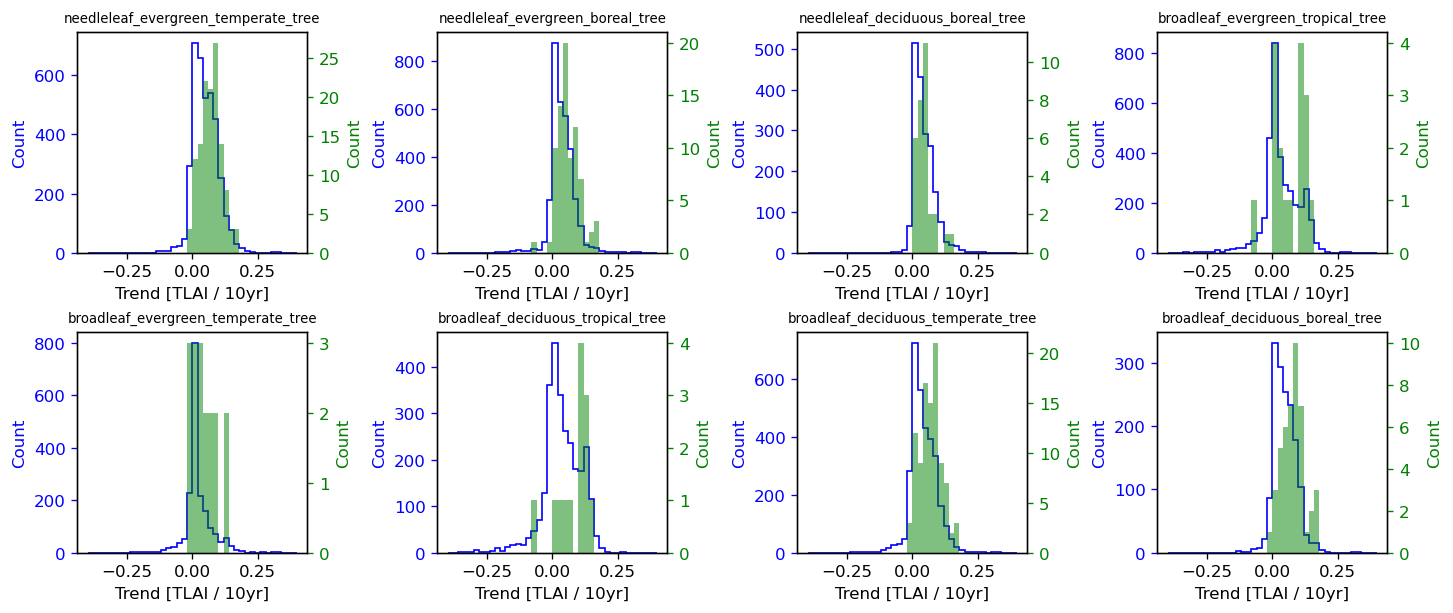

In [26]:
global_hist_h1('TLAI', np.arange(-0.4, 0.4+1e-5, 0.02), 'pft')

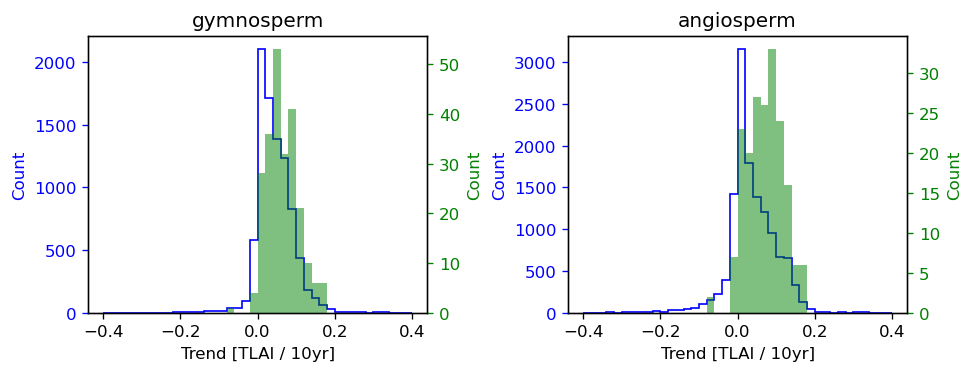

In [27]:
global_hist_h1('TLAI', np.arange(-0.4, 0.4+1e-5, 0.02), 'ang/gym')

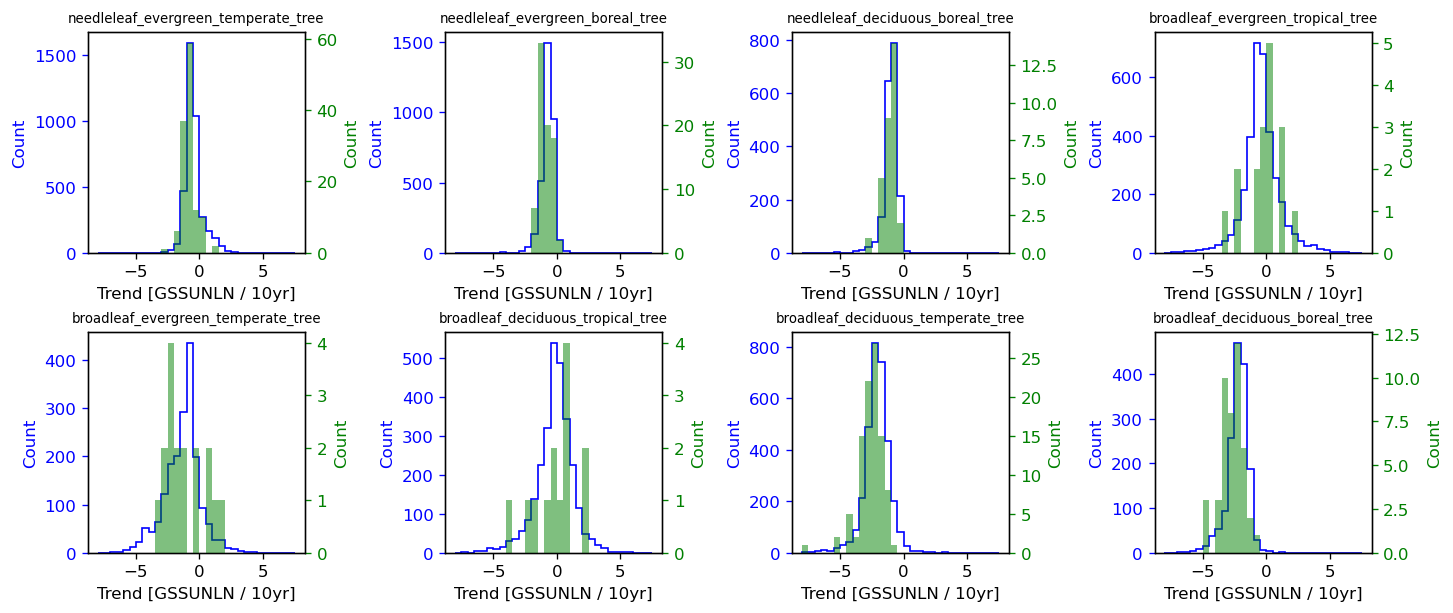

In [28]:
global_hist_h1('GSSUNLN', np.arange(-8, 8, 0.5), 'pft')

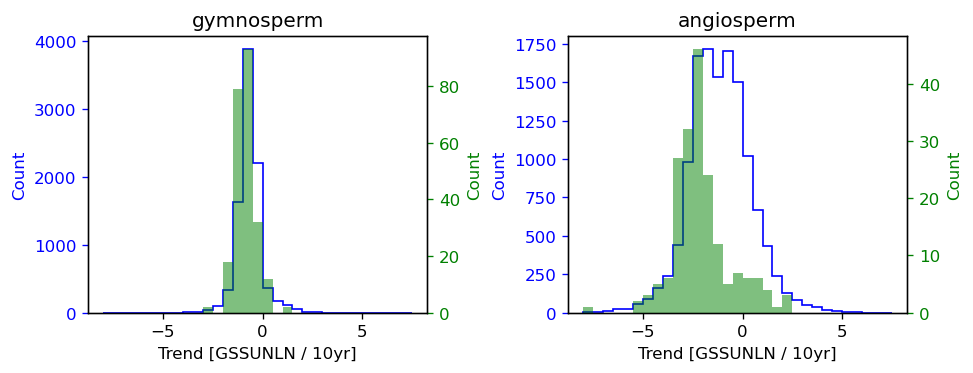

In [29]:
global_hist_h1('GSSUNLN', np.arange(-8, 8, 0.5), 'ang/gym')

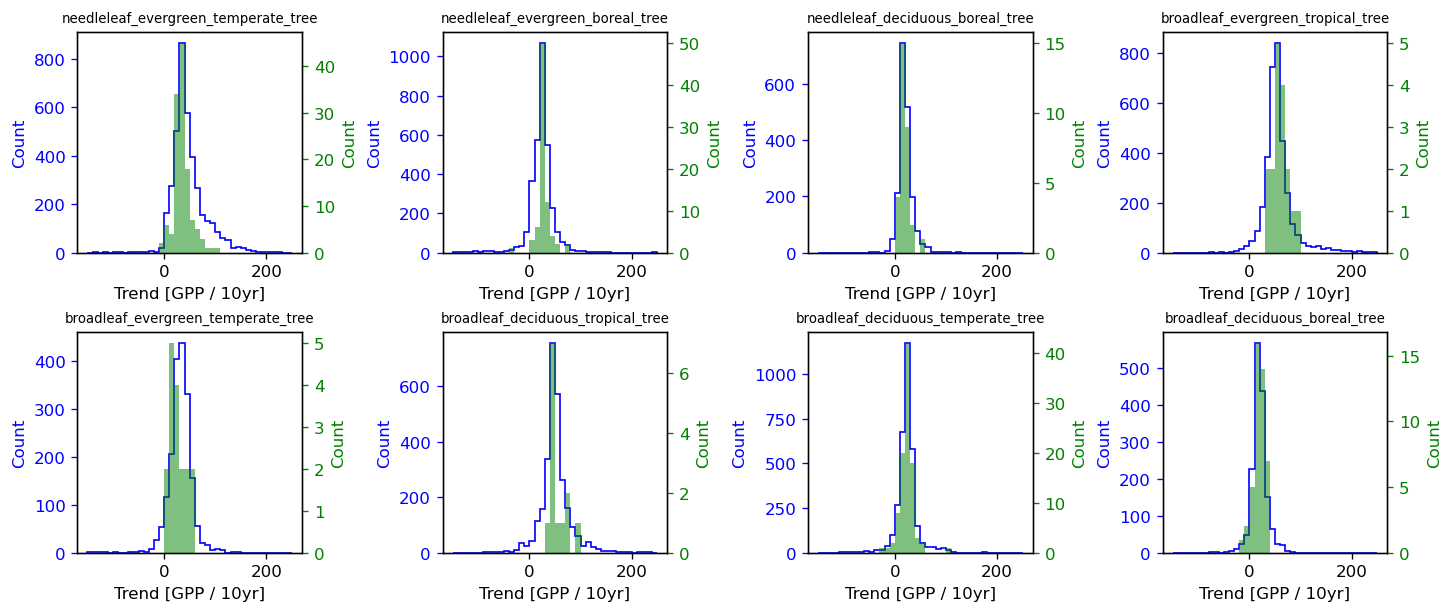

In [35]:
global_hist_h1('GPP', np.arange(-150, 250+1, 10), 'pft')

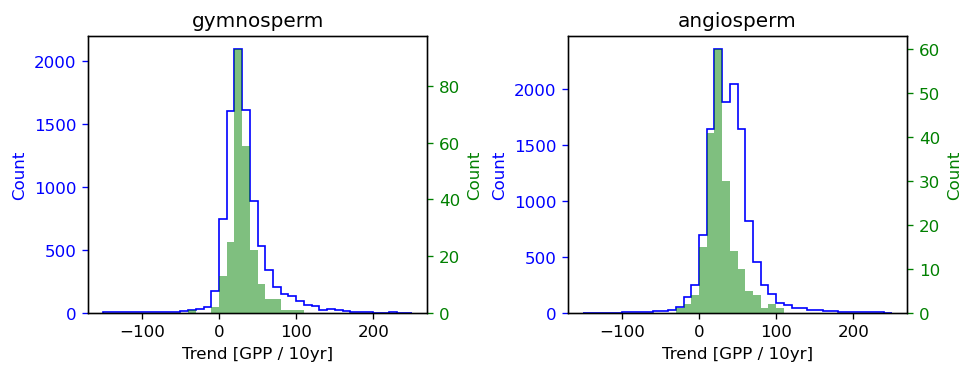

In [36]:
global_hist_h1('GPP', np.arange(-150, 250+1, 10), 'ang/gym')

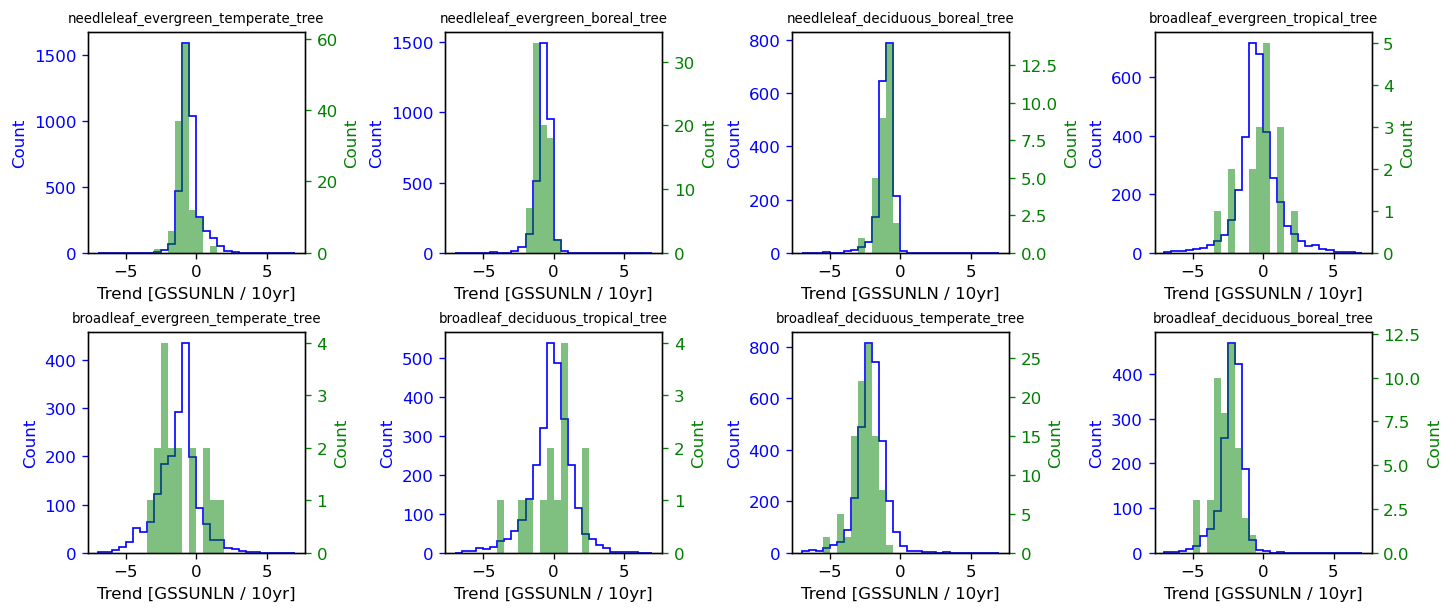

In [42]:
global_hist_h1('GSSUNLN', np.arange(-7, 7+1e-5, 0.5), 'pft')

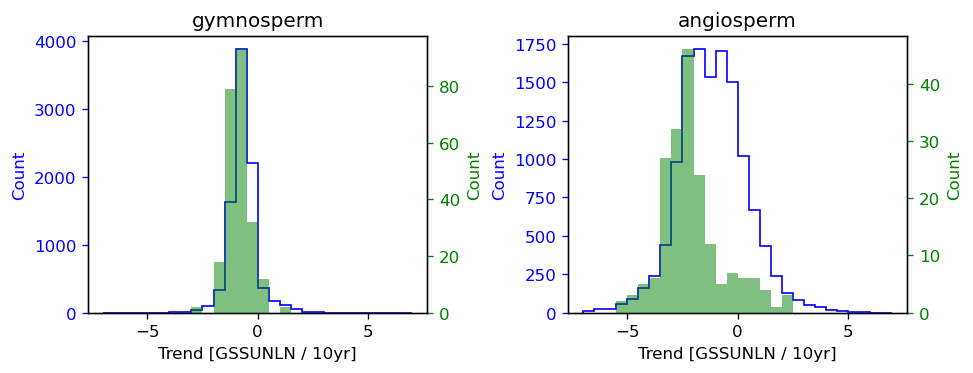

In [43]:
global_hist_h1('GSSUNLN', np.arange(-7, 7+1e-5, 0.5), 'ang/gym')

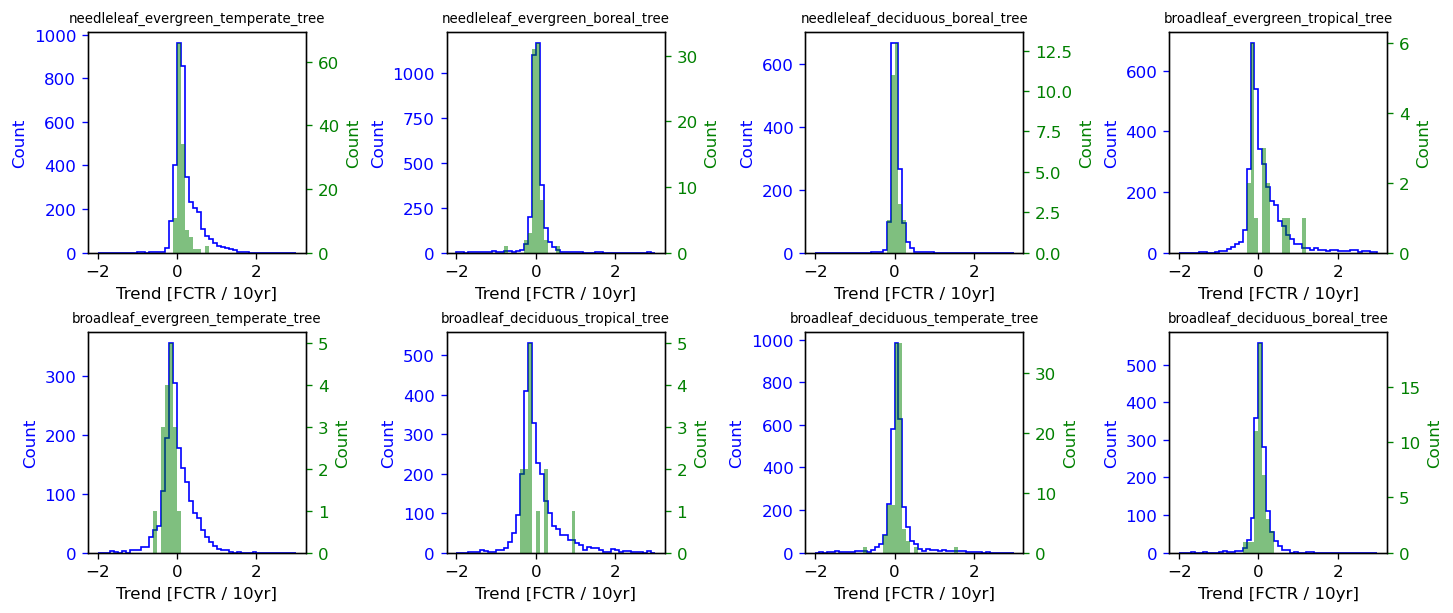

In [46]:
global_hist_h1('FCTR', np.arange(-2, 3+1e-5, 0.1), 'pft')

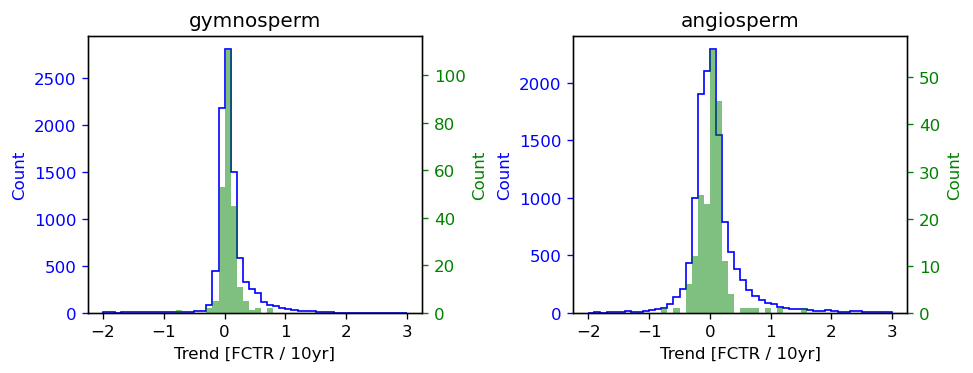

In [47]:
global_hist_h1('FCTR', np.arange(-2, 3+1e-5, 0.1), 'ang/gym')

# Bin by latitude

In [225]:
def bin_by_lat_band(these_slopes, lat_band_interval='30'):
    """
    Create lists of grid box values within each latitude band
    for site-level and gridbox-level output.
    """
    if lat_band_interval == '30':
        lat_bands = [
            [ 60,  90],
            [ 30,  60],
            [  0,  30],
            [-30,   0],
            [-60, -30],
            [-90, -60],
        ]
    if lat_band_interval == '180':
        lat_bands = [-90, 90]

    lat_band_avg = []

    for band in lat_bands:
        # (lat_bnd)
        if 'pft' not in these_slopes.dims:
            if 'site' in these_slopes.dims:
                these_slopes = replace_site_with_lat(these_slopes)

            slope = these_slopes.sel(lat=slice(band[0], band[1])).values.ravel()  
            slope = slope[~np.isnan(slope)]
            lat_band_avg.append(slope)
        
        # (lat_band,pft)
        else:
            if 'site' in these_slopes.dims:
                these_slopes = replace_site_with_lat(these_slopes)
            
            pft_slopes = []
            for pft in these_slopes.pft:
                slope = these_slopes.sel(pft=pft.values, lat=slice(band[0], band[1])).values.ravel()
                slope = slope[~np.isnan(slope)]
                pft_slopes.append(slope)

            lat_band_avg.append(pft_slopes)
    
    return lat_band_avg

In [226]:
time_period_keys = [
    'full',
    'early',
    'late',
]

latband_grid_slopes_h0 = {}
latband_site_slopes_h0 = {}
latband_unique_site_slopes_h0 = {}

latband_grid_slopes_h1 = {}
latband_site_slopes_h1 = {}
latband_unique_site_slopes_h1 = {}

for dd in [
    latband_grid_slopes_h0, latband_site_slopes_h0, latband_unique_site_slopes_h0,
    latband_grid_slopes_h1, latband_site_slopes_h1, latband_unique_site_slopes_h1,
    ]:
    dd['full'] = {}
    dd['early'] = {}
    dd['late'] = {}

for var in variable_h0:
    for period in time_period_keys:
        latband_grid_slopes_h0[period][var] = bin_by_lat_band(slopes_h0[period][var])
        latband_site_slopes_h0[period][var] = bin_by_lat_band(site_slopes_h0[period][var])
        latband_unique_site_slopes_h0[period][var] = bin_by_lat_band(unique_site_slopes_h0[period][var])
    
for var in variable_h1:
    for period in time_period_keys:
        latband_grid_slopes_h1[period][var] = bin_by_lat_band(slopes_h1[period][var])
        latband_site_slopes_h1[period][var] = bin_by_lat_band(site_slopes_h1[period][var])
        latband_unique_site_slopes_h1[period][var] = bin_by_lat_band(unique_site_slopes_h1[period][var])

## Climate h0 variables

In [227]:
def lat_band_hist_h0(time_period, var, var_units, bins):
    """
    """
    fig, axes = plt.subplots(
        5, 1, figsize=(5,8),
        layout='constrained',
        sharex=True,
    )
    ax_grid = axes.ravel()
    ax_site = np.empty(len(ax_grid), dtype=object)

    lat_band_descr = [
        '[60N,90N]',
        '[30N,60N]',
        '[0N,30N]',
        '[-30N,0N]',
        '[-60N,-30N]',
        '[-90N,-60N]',
    ]

    for i in range(5):
        n_grid = latband_grid_slopes_h0[time_period][var][i].size
        ax_grid[i].hist(
            latband_grid_slopes_h0[time_period][var][i],
            bins=bins,
            histtype='stepfilled',
            color='blue', alpha=0.5,
            label=f'all grid boxes (n={n_grid})')
        ax_grid[i].set_ylabel('Count')
        ax_grid[i].tick_params(axis='y', colors='blue')
        ax_grid[i].yaxis.label.set_color('blue')

        ax_site[i] = ax_grid[i].twinx()
        n_site = latband_site_slopes_h0[time_period][var][i].size
        ax_site[i].hist(
            latband_site_slopes_h0[time_period][var][i],
            bins=bins,
            histtype='stepfilled',
            color='green', alpha=0.5,
            label=f'sites (n={n_site})')
        ax_site[i].set_ylabel('Count')
        ax_site[i].tick_params(axis='y', colors='green')
        ax_site[i].yaxis.label.set_color('green')

        # Add legend
        grid_ln, grid_lb = ax_grid[i].get_legend_handles_labels()
        site_ln, site_lb = ax_site[i].get_legend_handles_labels()
        ax_grid[i].legend(
            grid_ln + site_ln, grid_lb + site_lb,
            loc='upper left', fontsize=8)
        
        # Add latitude band label
        ax_grid[i].text(
            -0.2, 0.5,
            lat_band_descr[i],
            fontsize=12,
            rotation=90, ha='center', va='center',
            transform=ax_grid[i].transAxes
        )

    ax_grid[-1].set_xlabel(f'Trend in {var} [{var_units}]')
    fig.suptitle(f'h0.{var}')

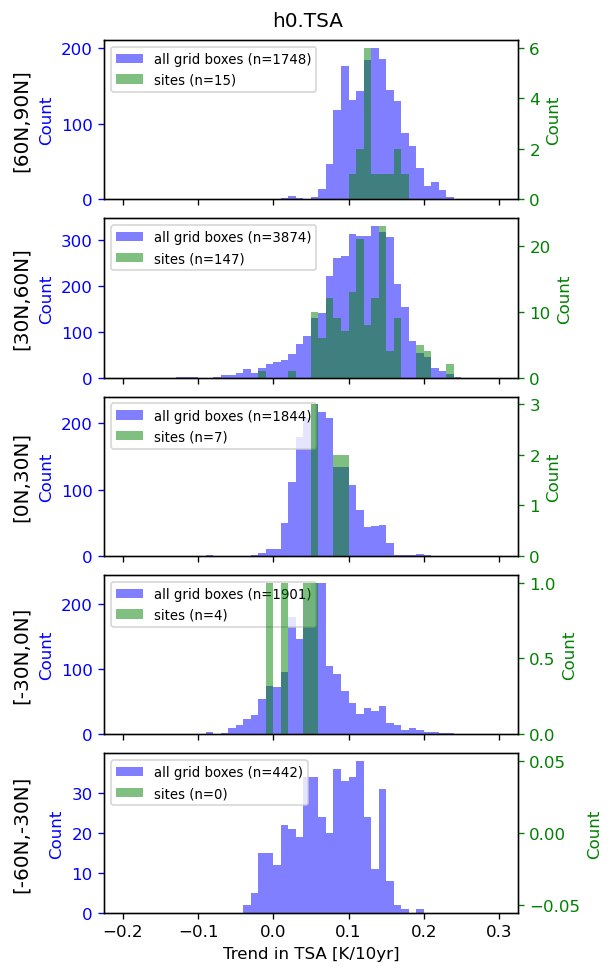

In [229]:
lat_band_hist_h0('full', 'TSA', 'K/10yr', np.arange(-0.2, 0.3+1e-5, 0.01))

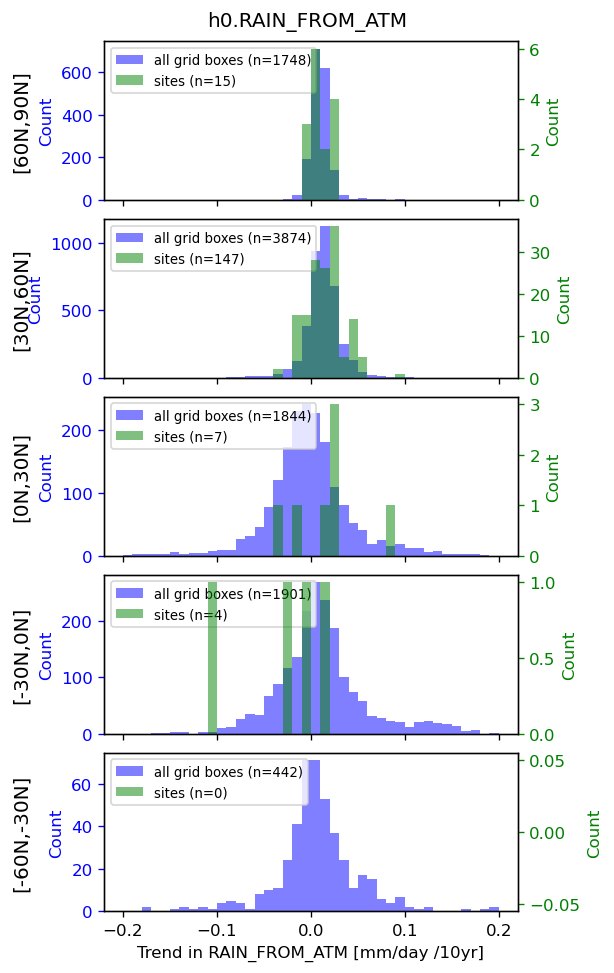

In [230]:
lat_band_hist_h0('full', 'RAIN_FROM_ATM', 'mm/day /10yr', np.arange(-0.2, 0.2+1e-5, 0.01))

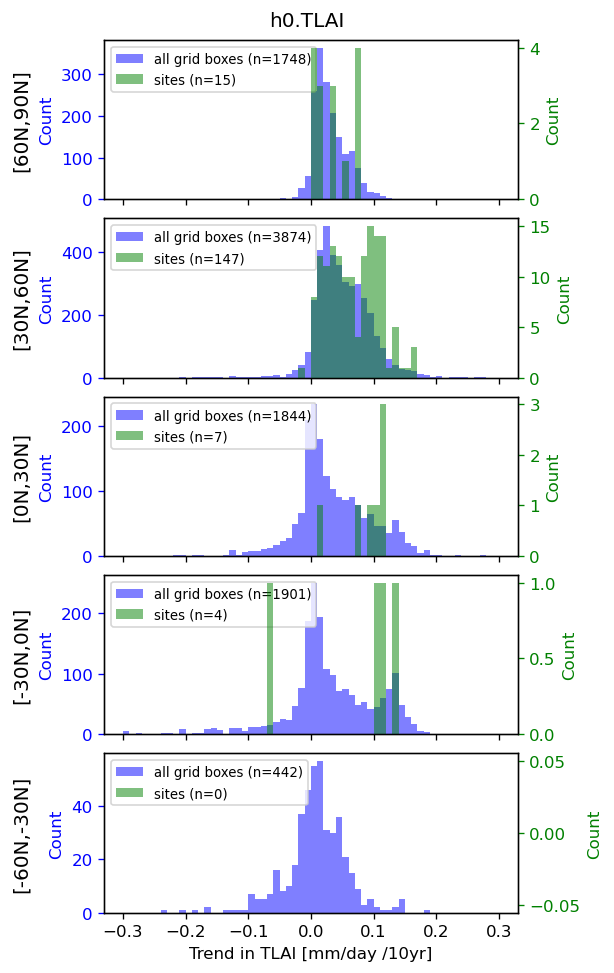

In [231]:
lat_band_hist_h0('full', 'TLAI', 'mm/day /10yr', np.arange(-0.3, 0.3+1e-5, 0.01))

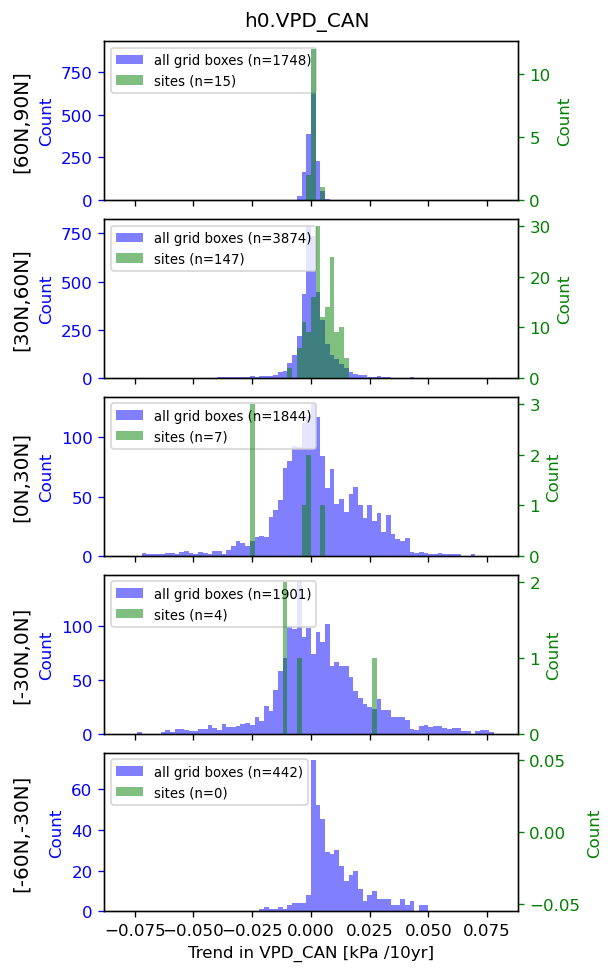

In [232]:
lat_band_hist_h0('full', 'VPD_CAN', 'kPa /10yr', np.arange(-0.08, 0.08+1e-5, 0.002))

## Vegetation h1 variables

In [233]:
def lat_band_hist_h1(time_period, var, var_units, bins):
    """
    Add docstring
    """
    fig, axes = plt.subplots(
        5, 8, figsize=(25,8),
        layout='constrained',
        sharex=True,
    )
    ax_grid = axes
    ax_site = np.empty(ax_grid.shape, dtype=object)

    lat_band_descr = [
        '[60N,90N]',
        '[30N,60N]',
        '[0N,30N]',
        '[-30N,0N]',
        '[-60N,-30N]',
        '[-90N,-60N]',
    ]

    for j in range(8):
        for i in range(5):
            n_grid = latband_grid_slopes_h1[time_period][var][i][j+1].size
            ax_grid[i,j].hist(
                latband_grid_slopes_h1[time_period][var][i][j+1],
                bins=bins,
                histtype='stepfilled',
                color='blue', alpha=0.5,
                label=f'all grid boxes (n={n_grid})')
            # ax_grid[i,j].set_ylabel('Count')
            ax_grid[i,j].tick_params(axis='y', colors='blue')
            ax_grid[i,j].yaxis.label.set_color('blue')

            ax_site[i,j] = ax_grid[i,j].twinx()
            n_site = latband_site_slopes_h1[time_period][var][i][j+1].size
            ax_site[i,j].hist(
                latband_site_slopes_h1[time_period][var][i][j+1],
                bins=bins,
                histtype='stepfilled',
                color='green', alpha=0.5,
                label=f'sites (n={n_site})')
            # ax_site[i,j].set_ylabel('Count')
            ax_site[i,j].tick_params(axis='y', colors='green')
            ax_site[i,j].yaxis.label.set_color('green')

            # # Add legend
            # grid_ln, grid_lb = ax_grid[i,j].get_legend_handles_labels()
            # site_ln, site_lb = ax_site[i,j].get_legend_handles_labels()
            # ax_grid[i,j].legend(
            #     grid_ln + site_ln, grid_lb + site_lb,
            #     loc='upper left', fontsize=8)
            
            # Add latitude band label
            if j == 0:
                ax_grid[i,j].text(
                    -0.2, 0.5,
                    lat_band_descr[i],
                    fontsize=12,
                    rotation=90, ha='center', va='center',
                    transform=ax_grid[i,j].transAxes
                )

        ax_grid[0,j].set_title(pftnames[j+1], fontsize=7)
        ax_grid[-1,j].set_xlabel(f'Trend in {var} [{var_units}]')
    
    fig.suptitle(f'h1.{var}')

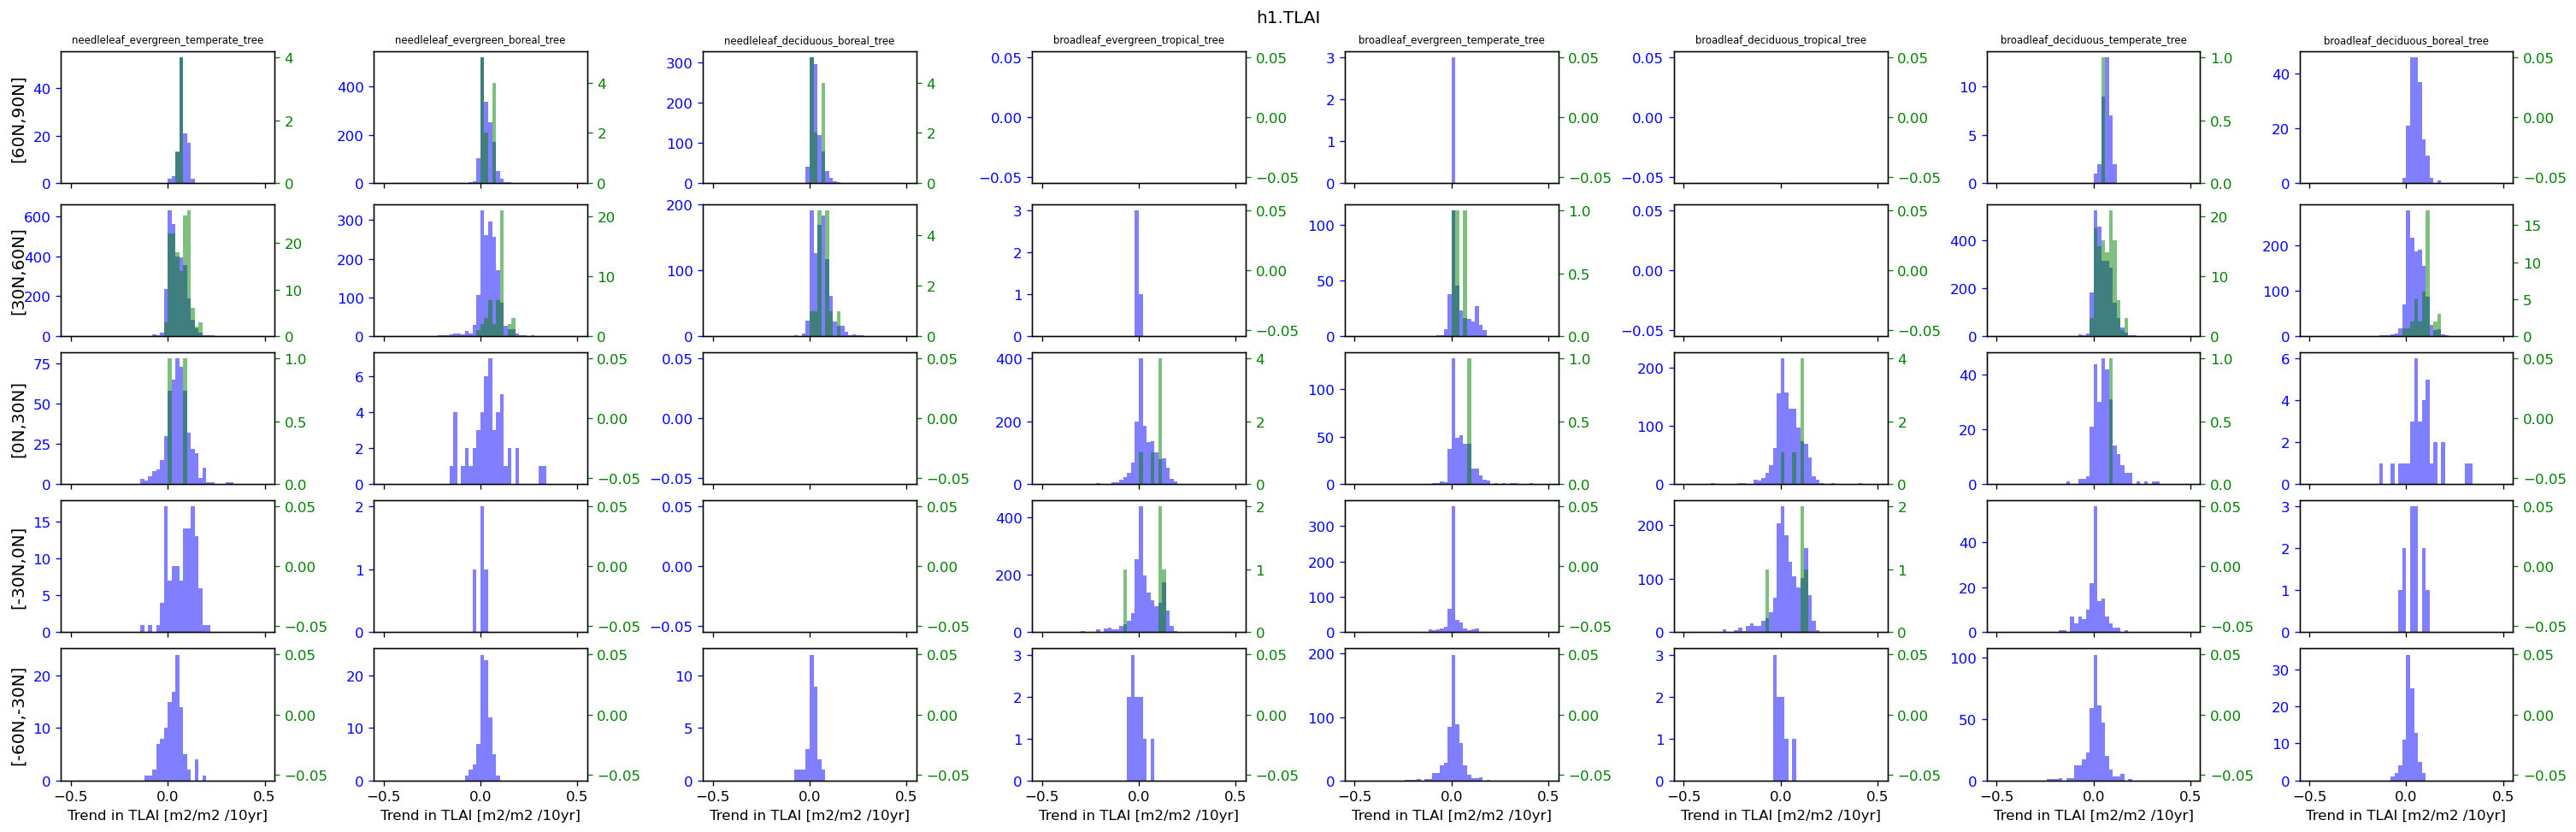

In [236]:
lat_band_hist_h1('full', 'TLAI', 'm2/m2 /10yr', np.arange(-0.5, 0.5+1e-5, 0.02))

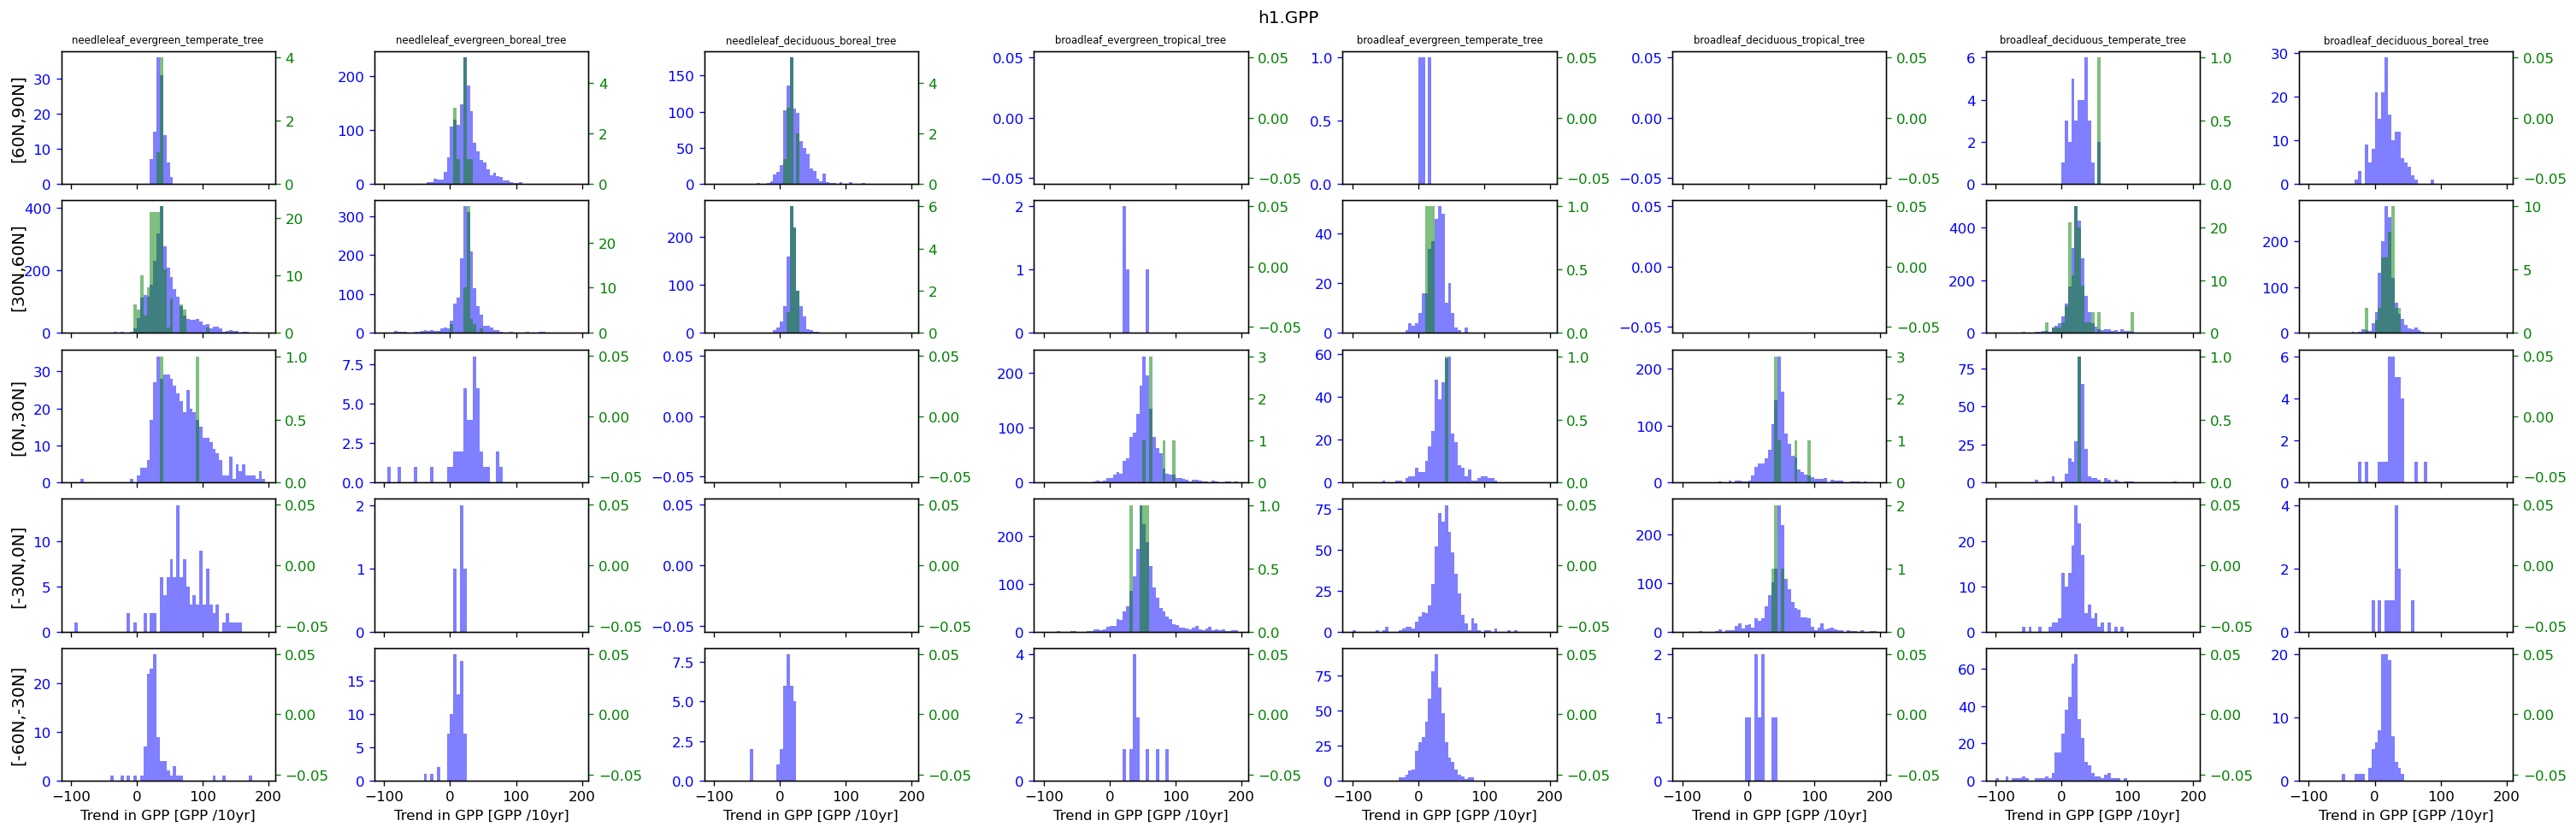

In [237]:
lat_band_hist_h1('full', 'GPP', 'GPP /10yr', np.arange(-100, 200, 5))

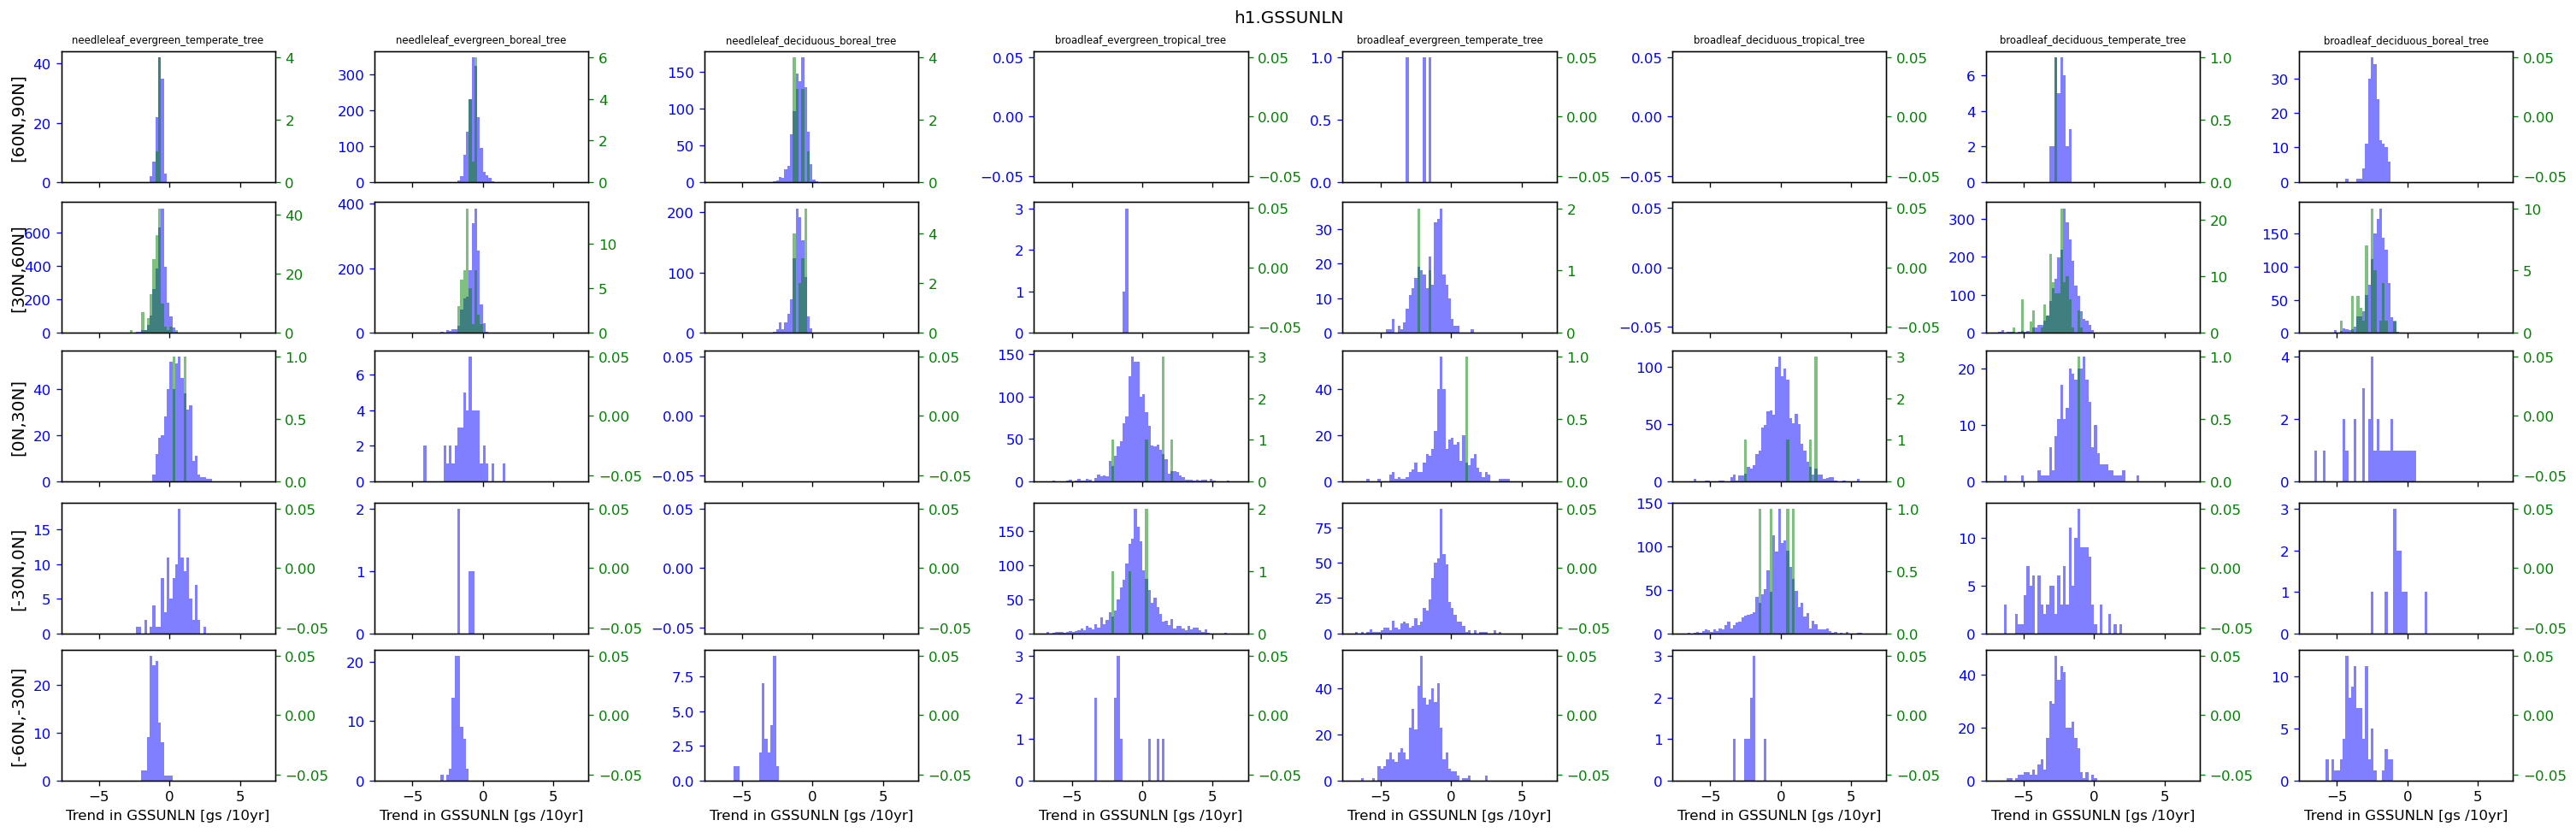

In [238]:
lat_band_hist_h1('full', 'GSSUNLN', 'gs /10yr', np.arange(-7, 7, 0.2))

# CHECKING LAI, AGAIN

In [ ]:
main_directory = '/glade/work/bbuchovecky/WUE_analysis'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'

lai = xr.open_dataset(f'{main_directory}/{case_name}.clm2.h1.TLAI.185001-201412_gridded.nc')['TLAI']
lai = lai.rename({'vegtype': 'pft', 'vegtype_name': 'pft_name'})

needle_lai = lai.sel(pft=slice(1,3))
broad_lai = lai.sel(pft=slice(4,8))

trunc_needle_lai = needle_lai.sel(time=slice('2005-01', '2014-12'))
trunc_broad_lai = broad_lai.sel(time=slice('2005-01', '2014-12'))

needle_tree_ring_coords = tree_ring_coords.loc[tree_ring_coords['PFT']<4].sort_values('PFT')
broad_tree_ring_coords = tree_ring_coords.loc[tree_ring_coords['PFT']>3].sort_values('PFT')

In [ ]:
%%time
site_trunch_needle_lai = select_sites_from_gridded_data(trunc_needle_lai, needle_tree_ring_coords.reset_index())
site_trunch_broad_lai = select_sites_from_gridded_data(trunc_broad_lai, broad_tree_ring_coords.reset_index())

CPU times: user 1.01 s, sys: 2.55 s, total: 3.56 s
Wall time: 53.3 s


In [ ]:
site_trunch_broad_lai

<xarray.DataArray 'TLAI' (site: 140, time: 120, pft: 5)>
array([[[1.1198219e-09, 6.9978223e-10, 0.0000000e+00, 0.0000000e+00,
                   nan],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                   nan],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                   nan],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                   nan],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                   nan],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                   nan]],

       [[4.9692984e+00,           nan, 6.4816561e+00,           nan,
                   nan],
        [4.4475007e+00,           nan, 5.7225761e+00,           nan,
                   nan],
        [4.4808893e+00,           nan, 5.7339315e+00,           nan,
                   nan],
...
        [          nan,           nan,           nan, 2.4435558e+00,
                   nan],
        [          nan,           nan,           nan, 1.1525456e+00,
                   nan],
        [          nan,           nan,           nan, 0.0000000e+00,
                   nan]],

       [[          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        ...,
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan]]], dtype=float32)
Coordinates:
  * time      (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
  * pft       (pft) int64 4 5 6 7 8
    pft_name  (pft) |S40 b'broadleaf_evergreen_tropical_tree       ' ... b'br...
    lat       (site) float32 8.01 -7.068 5.183 15.55 ... 48.53 35.34 59.84 56.07
    lon       (site) float32 38.75 111.2 0.0 98.75 82.5 ... 1.25 0.0 22.5 0.0
  * site      (site) int64 0 1 2 3 4 5 6 7 8 ... 132 133 134 135 136 137 138 139
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

In [ ]:
site_trunch_broad_lai.size

84000

In [ ]:
str(site_trunch_broad_lai.isel(pft=0).pft_name.item().strip())[2:-1]

'broadleaf_evergreen_tropical_tree'

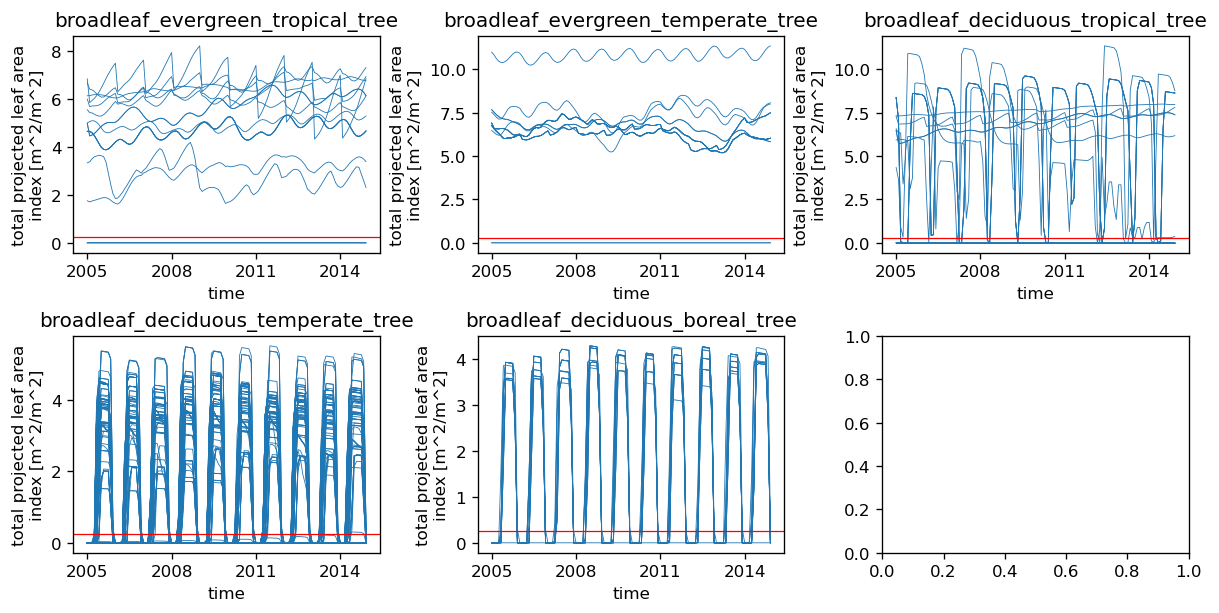

In [ ]:
fig, axes = plt.subplots(
    2, 3, figsize=(10, 5),
    layout='constrained'
)
ax = axes.ravel()

for i in range(5):
    for s in range(site_trunch_broad_lai.site.size):
        site_trunch_broad_lai.isel(site=s, pft=i).plot(ax=ax[i], c='tab:blue', lw='0.5')
    ax[i].axhline(0.25, c='red', lw=0.75)
    ax[i].set_title(str(site_trunch_broad_lai.isel(pft=i).pft_name.item().strip())[2:-1])

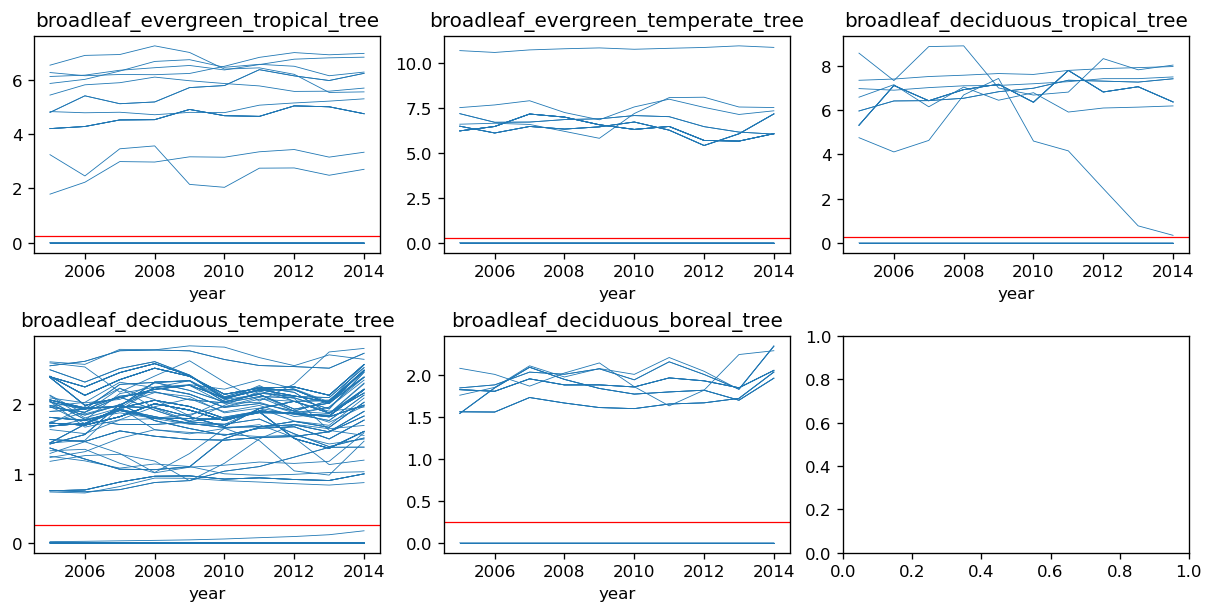

In [ ]:
fig, axes = plt.subplots(
    2, 3, figsize=(10, 5),
    layout='constrained'
)
ax = axes.ravel()

for i in range(5):
    for s in range(site_trunch_broad_lai.site.size):
        annts = calculate_annual_timeseries(site_trunch_broad_lai.isel(site=s, pft=i))
        annts.plot(ax=ax[i], c='tab:blue', lw='0.5')
    ax[i].axhline(0.25, c='red', lw=0.75)
    ax[i].set_title(str(site_trunch_broad_lai.isel(pft=i).pft_name.item().strip())[2:-1])